## Project 1: Tourism
### Author: Ulises Gallardo Rodríguez 0229261

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display_html 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack
import nltk
nltk.download('stopwords')
nltk.download('stopwords', quiet=True, raise_on_error=True, halt_on_error=False)
from nltk.corpus import stopwords
import re #Expresiones regulares
from deep_translator import GoogleTranslator #pip install deep-translator

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ulises\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Util Functions

In [214]:
def generate_cloud_of_words(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white", 
                          colormap="viridis", max_words=50).generate(text)
    
    plt.figure(figsize=(8,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize = 20, fontstyle = 'oblique')
    plt.show()

In [199]:
def remove_stop_words(texto):
    stop_words = set(stopwords.words('spanish'))
    texto_sin_stop_words = ' '.join([palabra for palabra in texto.split() if palabra.lower() not in stop_words])
    return texto_sin_stop_words

In [200]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(32, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [201]:
def plot_histogram_or_countplot(df, column):
    fig, ax = plt.subplots()
    if df[column].dtype == 'O':
        if column == 'País':
            country_counts = df[column].value_counts()
            top_n = 5
            countries_to_plot = country_counts.index[:top_n]
            df_to_plot = df[df[column].isin(countries_to_plot)]
            sns.countplot(x=column, data=df_to_plot, ax=ax)
        else:
            sns.countplot(x=column, data=df, ax=ax)
        ax.set_ylabel('Frecuencia')
    else:
        ax.hist(df[column])
        ax.set_xlabel(column)
        ax.set_ylabel('Frecuencia')
        ax.set_title(f'Histograma de {column}')
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return image


In [203]:
def get_vocabulary(textos): 
    vectorizador = CountVectorizer()
    vectorizador.fit_transform(textos)
    vocabulario = vectorizador.get_feature_names_out()
    return vocabulario

In [184]:
def BOW(textos,vocabulario):
    vectorizador = CountVectorizer(vocabulary=vocabulario)
    BOW = vectorizador.fit_transform(textos)
    return BOW

In [204]:
def LSA(X, y):
    c = X.shape[1]
    select = min(c,50)
    feats = SelectKBest(chi2,k=select)
    feats.fit(X,y)
    best = feats.get_support(indices=True)
    return best

In [223]:
def plot_year(series, colores, nombres, years):
    if len(series) != len(colores) or len(series) != len(nombres):
        raise ValueError("Las tres series deben tener el mismo tamaño")
    for serie, color, nombre in zip(series, colores, nombres):
        plt.plot(serie,label=nombre, color=color)
    plt.title("Críticas por año")
    plt.xticks(range(len(years)), years)
    plt.legend()
    plt.show()

In [206]:
def temporal_analisis_year(df):
    df['Fecha'] = df['Fecha'].astype(str)
    dates = np.unique(np.array(df['Fecha']))
    years = np.unique([date.split("-")[0] for date in dates])
    frecuency = np.zeros((3, years.shape[0]))
    for idx, year in enumerate(years):
        df_by_date = df.loc[df['Fecha'].str.contains(year, case=False)]
        frecuency[0][idx] = len(df_by_date[df_by_date['Sentimiento'] == 'positivo'])
        frecuency[1][idx] = len(df_by_date[df_by_date['Sentimiento'] == 'neutral'])
        frecuency[2][idx] = len(df_by_date[df_by_date['Sentimiento'] == 'negativo'])

    colores = ['blue', 'red', 'orange']
    nombres = [ "Positivo", "Neutro", "Negativo"]
    plot_year(frecuency,colores,nombres, years)

In [221]:
def plot_mean(frequencies, colors, names, years):
    promedios = np.mean(frequencies, axis=1)
    
    fig, ax = plt.subplots()
    
    for i in range(len(names)):
        ax.plot(promedios[i], label=names[i], color=colors[i])
    ax.set_title("Críticas por mes")
    ax.set_xlabel("Mes")
    ax.set_ylabel("Promedio de Frecuencia")
    ax.set_xticks(np.arange(12))
    ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
    ax.legend()
    plt.show()

In [208]:
def temporal_analisis_months(df):
    df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m-%d')
    df['Mes'] = df['Fecha'].dt.month
    df['Año'] = df['Fecha'].dt.year
    
    years = np.unique(df['Año'])
    frequencies = np.zeros((3, len(years), 12))
    
    for i, year in enumerate(years):
        year_df = df[df['Año'] == year]
        
        for j in range(1, 13):
            month_df = year_df[year_df['Mes'] == j]
            frequencies[0, i, j-1] = len(month_df[month_df['Sentimiento'] == 'positivo'])
            frequencies[1, i, j-1] = len(month_df[month_df['Sentimiento'] == 'neutral'])
            frequencies[2, i, j-1] = len(month_df[month_df['Sentimiento'] == 'negativo'])
    
    colors = ['blue', 'red', 'orange']
    names = ["Positivo", "Neutro", "Negativo"]
    
    plot_mean(frequencies, colors, names, years)

In [209]:
def top_topics(textos, top_words = 10):
    stop_words_spanish = set(stopwords.words('spanish'))
    vectorizer = TfidfVectorizer(norm='l2', stop_words = stop_words_spanish)
    TFIDF = vectorizer.fit_transform(textos)
    svd = TruncatedSVD(n_components=3)
    lsa = svd.fit_transform(TFIDF)
    #topic_enfoded_df = pd.DataFrame(lsa,columns=["topic_1","topic_2","topic_3"])
    #topic_enfoded_df["body"] = textos
    #display(topic_enfoded_df[["body","topic_1","topic_2","topic_3"]])
    topics = ['topic_1','topic_2','topic_3']
    dictionary = vectorizer.get_feature_names_out()
    encoding_matrix = pd.DataFrame(svd.components_, index=topics).T
    encoding_matrix['terms'] = dictionary
    topic_words_all = []
    for topic in topics:
        encoding_matrix['abs_'+topic] = np.abs(encoding_matrix[topic])
        topic_words = encoding_matrix.sort_values('abs_'+topic, ascending=False).head(top_words)[[topic, 'terms']].style.set_table_attributes("style='display:inline'").set_caption(topic)
        topic_words_all.append(topic_words._repr_html_())
    display_html(topic_words_all, raw=True)

In [216]:
def top_features(documents, labels):
    stop_words_spanish = set(stopwords.words('spanish'))
    vectorizer = TfidfVectorizer(norm='l2', stop_words = stop_words_spanish, max_features=1000)
    vectorizer_bigram = TfidfVectorizer(norm='l2', stop_words = stop_words_spanish, max_features=2000)
    vectorizer_trigram = TfidfVectorizer(norm='l2', stop_words = stop_words_spanish, max_features=1000)

    X_terms = vectorizer.fit_transform(documents)
    X_bigrams = vectorizer_bigram.fit_transform(documents)
    X_trigrams = vectorizer_trigram.fit_transform(documents)

    X = hstack([X_terms, X_bigrams, X_trigrams])
    
    k = 1000
    selector = SelectKBest(score_func=chi2, k=k)
    X_selected = selector.fit_transform(X, labels)
    selected_feature_indices = selector.get_support(indices=True)
    feature_names_all = [vectorizer.get_feature_names_out() , vectorizer_bigram.get_feature_names_out() , vectorizer_trigram.get_feature_names_out()]
    feature_names = []
    for feature_name in feature_names_all:
        feature_names.extend(feature_name)

    feature_names = np.array(feature_names)
    mask = selector.get_support()
    selected_features = feature_names[mask]

    text = ' '.join(selected_features)
    generate_cloud_of_words(text, 'BOW+BIGRAM+TRIGRAM')
    

## Preprocessing

In [211]:
def translate_text(s, target = 'es'):
    translated = GoogleTranslator(source='auto', target=target).translate(s)
    return translated

In [212]:
translate_text("こんにちは、私の名前はウリセスです。これはテキスト翻訳に関するテストです。")

'Hola, mi nombre es Ulises. Esta es una prueba de traducción de texto.'

In [81]:
import os
def read_files(path,name_places):
    archivos = os.listdir("./")
    names = []
    places = []
    for archivo in archivos:
        if archivo in name_places:
            file = pd.read_csv(archivo)
            places.append(file)
            names.append(archivo)
    return places, names

In [121]:
xls = pd.ExcelFile('./Opiniones Tripadvisor_nlp_2023.xlsx')
sheet_to_df_map = {}
places = []
name_places = []
idx = 0

for sheet_name in xls.sheet_names:
    sheet_to_df_map[sheet_name] = xls.parse(sheet_name)
    df = pd.DataFrame(data = sheet_to_df_map[sheet_name])
    name = sheet_name.split(" ")
    name = ''.join(name[:len(name)-1])+".csv"
    
    mapeo = {4: 'positivo', 5: 'positivo', 3: 'neutral', 2: 'negativo', 1: 'negativo'}
    df['Sentimiento'] = df['Escala'].map(mapeo)
    df['Fecha'] = df['Fecha'].dt.strftime('%Y-%m-%d')
    df['Opinión'] = df['Opinión'].apply(translate_text)
    df.to_csv(name, index=False, encoding = 'utf-8-sig')
    places.append(df)
    
    name_places.append(name)
    idx+=1
places, name_places = read_files("./", name_places)

## EDA

Algunos pasos para procesar las opiniones: tener todos los comentarios en un mismo idioma, pasar todo el texto a minusculas y quitar stop words. 

Alhóndiga
Promedio Puntaje:  4.45 Desviación Estandar: 0.75
Promedio Longitud 46.86 Desviación Estandar 34.16


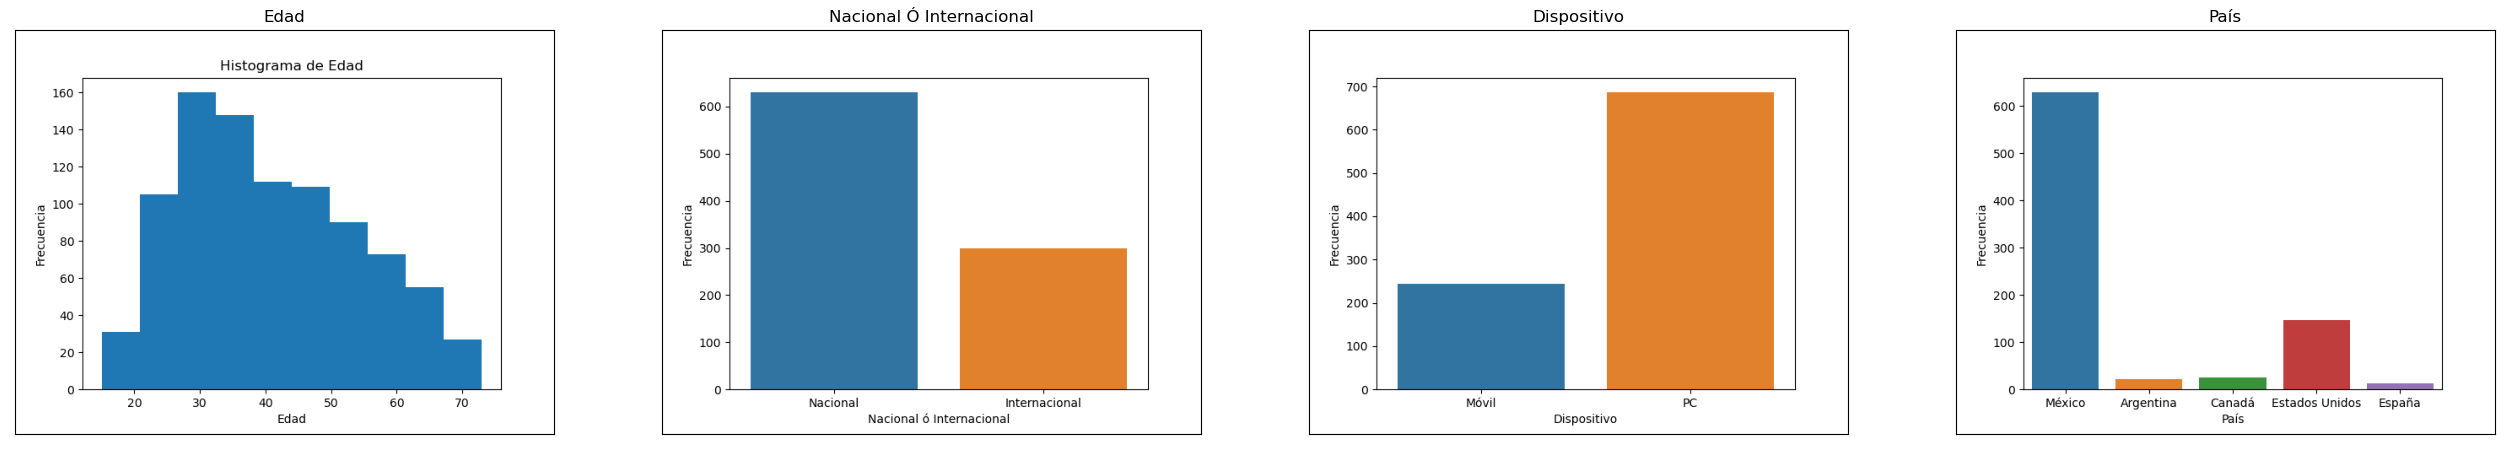

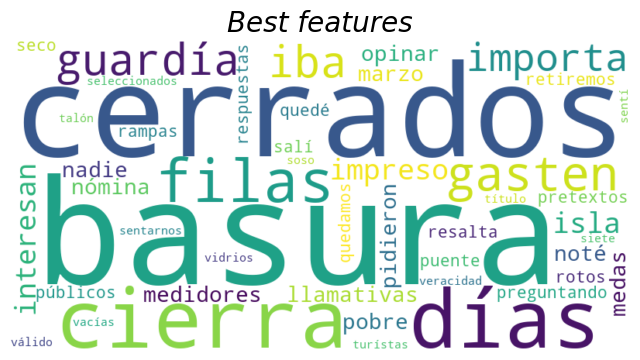

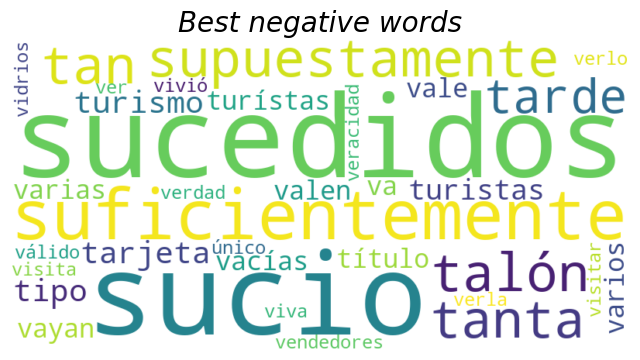

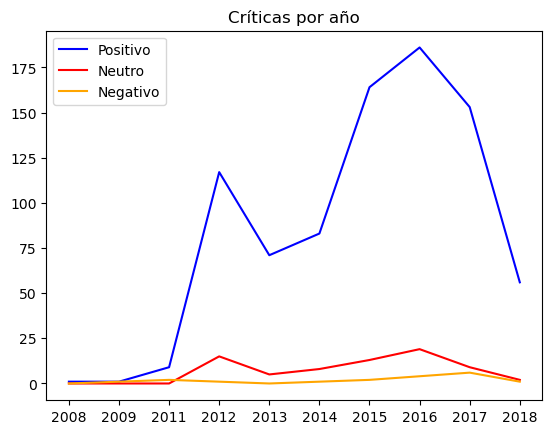

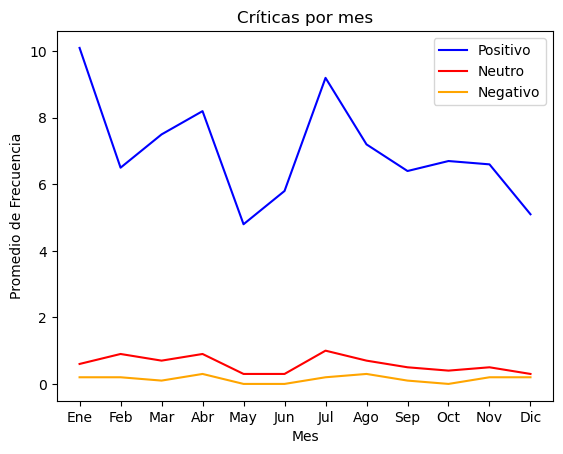

Hombres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2206 
 0.341896 
 historia 
 
 
 2683 
 0.320123 
 lugar 
 
 
 2957 
 0.247498 
 méxico 
 
 
 2943 
 0.236894 
 museo 
 
 
 2374 
 0.208680 
 independencia 
 
 
 2083 
 0.187201 
 guanajuato 
 
 
 4039 
 0.162276 
 si 
 
 
 1471 
 0.151190 
 edificio 
 
 
 4558 
 0.136683 
 visitar 
 
 
 4549 
 0.133644 
 visita 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2683 
 0.515320 
 lugar 
 
 
 1471 
 -0.282270 
 edificio 
 
 
 4558 
 0.194126 
 visitar 
 
 
 2938 
 -0.181118 
 murales 
 
 
 2943 
 -0.162498 
 museo 
 
 
 914 
 0.160872 
 conocer 
 
 
 1801 
 -0.158830 
 exhibiciones 
 
 
 3935 
 -0.141752 
 salas 
 
 
 2206 
 0.136338 
 historia 
 
 
 1691 
 -0.133538 
 español 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2957 
 -0.362076 
 méxico 
 
 
 2374 
 -0.350241 
 independencia 
 
 
 3247 
 0.339569 
 pena 
 
 
 4437 
 0.326169 
 vale 
 
 
 4039 
 0.267529 
 si 
 
 
 4549 
 0.172396 
 visita 
 
 
 2206 
 -0.126735 
 historia 
 
 
 914 
 -0.116565 
 conocer 
 
 
 4461 
 0.112815 
 vas 
 
 
 1801 
 0.100823 
 exhibiciones

Mujeres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2206 
 0.341898 
 historia 
 
 
 2683 
 0.320123 
 lugar 
 
 
 2957 
 0.247496 
 méxico 
 
 
 2943 
 0.236896 
 museo 
 
 
 2374 
 0.208681 
 independencia 
 
 
 2083 
 0.187196 
 guanajuato 
 
 
 4039 
 0.162276 
 si 
 
 
 1471 
 0.151190 
 edificio 
 
 
 4558 
 0.136680 
 visitar 
 
 
 4549 
 0.133651 
 visita 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2683 
 0.514578 
 lugar 
 
 
 1471 
 -0.280589 
 edificio 
 
 
 4558 
 0.198950 
 visitar 
 
 
 2938 
 -0.178729 
 murales 
 
 
 2943 
 -0.170012 
 museo 
 
 
 914 
 0.162904 
 conocer 
 
 
 1801 
 -0.154227 
 exhibiciones 
 
 
 3935 
 -0.140719 
 salas 
 
 
 2206 
 0.137586 
 historia 
 
 
 2635 
 0.130320 
 lleno 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2957 
 -0.357239 
 méxico 
 
 
 3247 
 0.349533 
 pena 
 
 
 2374 
 -0.346925 
 independencia 
 
 
 4437 
 0.338049 
 vale 
 
 
 4039 
 0.220616 
 si 
 
 
 4549 
 0.182404 
 visita 
 
 
 3179 
 -0.140024 
 parte 
 
 
 2206 
 -0.121045 
 historia 
 
 
 2324 
 -0.115669 
 importante 
 
 
 1607 
 0.108290 
 entrada

Turistas Nacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2206 
 0.341901 
 historia 
 
 
 2683 
 0.320125 
 lugar 
 
 
 2957 
 0.247499 
 méxico 
 
 
 2943 
 0.236896 
 museo 
 
 
 2374 
 0.208674 
 independencia 
 
 
 2083 
 0.187203 
 guanajuato 
 
 
 4039 
 0.162272 
 si 
 
 
 1471 
 0.151190 
 edificio 
 
 
 4558 
 0.136682 
 visitar 
 
 
 4549 
 0.133642 
 visita 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2683 
 0.523223 
 lugar 
 
 
 1471 
 -0.282344 
 edificio 
 
 
 4558 
 0.192860 
 visitar 
 
 
 2943 
 -0.186537 
 museo 
 
 
 2938 
 -0.177466 
 murales 
 
 
 3935 
 -0.152864 
 salas 
 
 
 914 
 0.144531 
 conocer 
 
 
 1801 
 -0.142039 
 exhibiciones 
 
 
 2206 
 0.136855 
 historia 
 
 
 2635 
 0.129387 
 lleno 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 3247 
 0.391509 
 pena 
 
 
 4437 
 0.376698 
 vale 
 
 
 2374 
 -0.332920 
 independencia 
 
 
 2957 
 -0.314285 
 méxico 
 
 
 4549 
 0.190178 
 visita 
 
 
 4039 
 0.168441 
 si 
 
 
 2206 
 -0.124842 
 historia 
 
 
 1471 
 -0.118956 
 edificio 
 
 
 1607 
 0.109277 
 entrada 
 
 
 4560 
 0.099311 
 visitarlo

Turistas Internacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2206 
 0.341892 
 historia 
 
 
 2683 
 0.320127 
 lugar 
 
 
 2957 
 0.247501 
 méxico 
 
 
 2943 
 0.236902 
 museo 
 
 
 2374 
 0.208682 
 independencia 
 
 
 2083 
 0.187211 
 guanajuato 
 
 
 4039 
 0.162265 
 si 
 
 
 1471 
 0.151181 
 edificio 
 
 
 4558 
 0.136684 
 visitar 
 
 
 4549 
 0.133651 
 visita 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2683 
 0.512130 
 lugar 
 
 
 1471 
 -0.277647 
 edificio 
 
 
 4558 
 0.201394 
 visitar 
 
 
 2938 
 -0.179129 
 murales 
 
 
 2943 
 -0.166154 
 museo 
 
 
 914 
 0.159683 
 conocer 
 
 
 1801 
 -0.154217 
 exhibiciones 
 
 
 3935 
 -0.137232 
 salas 
 
 
 2206 
 0.133177 
 historia 
 
 
 1691 
 -0.127469 
 español 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 3247 
 0.344420 
 pena 
 
 
 2374 
 -0.343639 
 independencia 
 
 
 2957 
 -0.342795 
 méxico 
 
 
 4437 
 0.330817 
 vale 
 
 
 4549 
 0.215276 
 visita 
 
 
 4039 
 0.205050 
 si 
 
 
 3179 
 -0.142243 
 parte 
 
 
 914 
 -0.133613 
 conocer 
 
 
 2206 
 -0.129993 
 historia 
 
 
 1471 
 -0.126042 
 edificio

Personas Jovenes


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2206 
 0.341897 
 historia 
 
 
 2683 
 0.320124 
 lugar 
 
 
 2957 
 0.247499 
 méxico 
 
 
 2943 
 0.236891 
 museo 
 
 
 2374 
 0.208681 
 independencia 
 
 
 2083 
 0.187193 
 guanajuato 
 
 
 4039 
 0.162277 
 si 
 
 
 1471 
 0.151191 
 edificio 
 
 
 4558 
 0.136684 
 visitar 
 
 
 4549 
 0.133644 
 visita 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2683 
 0.515450 
 lugar 
 
 
 1471 
 -0.276326 
 edificio 
 
 
 4558 
 0.204441 
 visitar 
 
 
 2938 
 -0.175516 
 murales 
 
 
 2943 
 -0.171477 
 museo 
 
 
 914 
 0.160347 
 conocer 
 
 
 1801 
 -0.155864 
 exhibiciones 
 
 
 1691 
 -0.136880 
 español 
 
 
 2206 
 0.133727 
 historia 
 
 
 3935 
 -0.132590 
 salas 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 3247 
 0.358717 
 pena 
 
 
 4437 
 0.348038 
 vale 
 
 
 2374 
 -0.341057 
 independencia 
 
 
 2957 
 -0.333601 
 méxico 
 
 
 4039 
 0.245181 
 si 
 
 
 4549 
 0.180437 
 visita 
 
 
 3179 
 -0.124253 
 parte 
 
 
 1471 
 -0.120662 
 edificio 
 
 
 2324 
 -0.106225 
 importante 
 
 
 1607 
 0.105739 
 entrada

Personas Mayor


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2206 
 0.341887 
 historia 
 
 
 2683 
 0.320127 
 lugar 
 
 
 2957 
 0.247505 
 méxico 
 
 
 2943 
 0.236898 
 museo 
 
 
 2374 
 0.208684 
 independencia 
 
 
 2083 
 0.187198 
 guanajuato 
 
 
 4039 
 0.162269 
 si 
 
 
 1471 
 0.151183 
 edificio 
 
 
 4558 
 0.136686 
 visitar 
 
 
 4549 
 0.133645 
 visita 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2683 
 0.509554 
 lugar 
 
 
 1471 
 -0.279018 
 edificio 
 
 
 4558 
 0.208321 
 visitar 
 
 
 2938 
 -0.183906 
 murales 
 
 
 914 
 0.163235 
 conocer 
 
 
 1801 
 -0.154886 
 exhibiciones 
 
 
 2943 
 -0.152539 
 museo 
 
 
 2206 
 0.136525 
 historia 
 
 
 1691 
 -0.134505 
 español 
 
 
 3935 
 -0.132909 
 salas 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 3247 
 0.382161 
 pena 
 
 
 4437 
 0.368726 
 vale 
 
 
 2374 
 -0.345213 
 independencia 
 
 
 2957 
 -0.341401 
 méxico 
 
 
 4039 
 0.192148 
 si 
 
 
 4549 
 0.182084 
 visita 
 
 
 3179 
 -0.120719 
 parte 
 
 
 2206 
 -0.112899 
 historia 
 
 
 1471 
 -0.112206 
 edificio 
 
 
 914 
 -0.107531 
 conocer

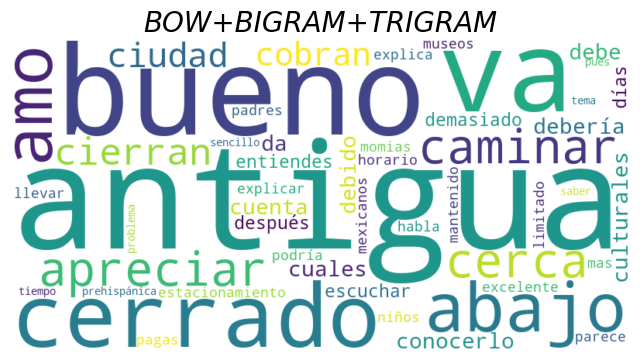

BasilicaColegiata
Promedio Puntaje:  4.5 Desviación Estandar: 0.67
Promedio Longitud 39.79 Desviación Estandar 29.4


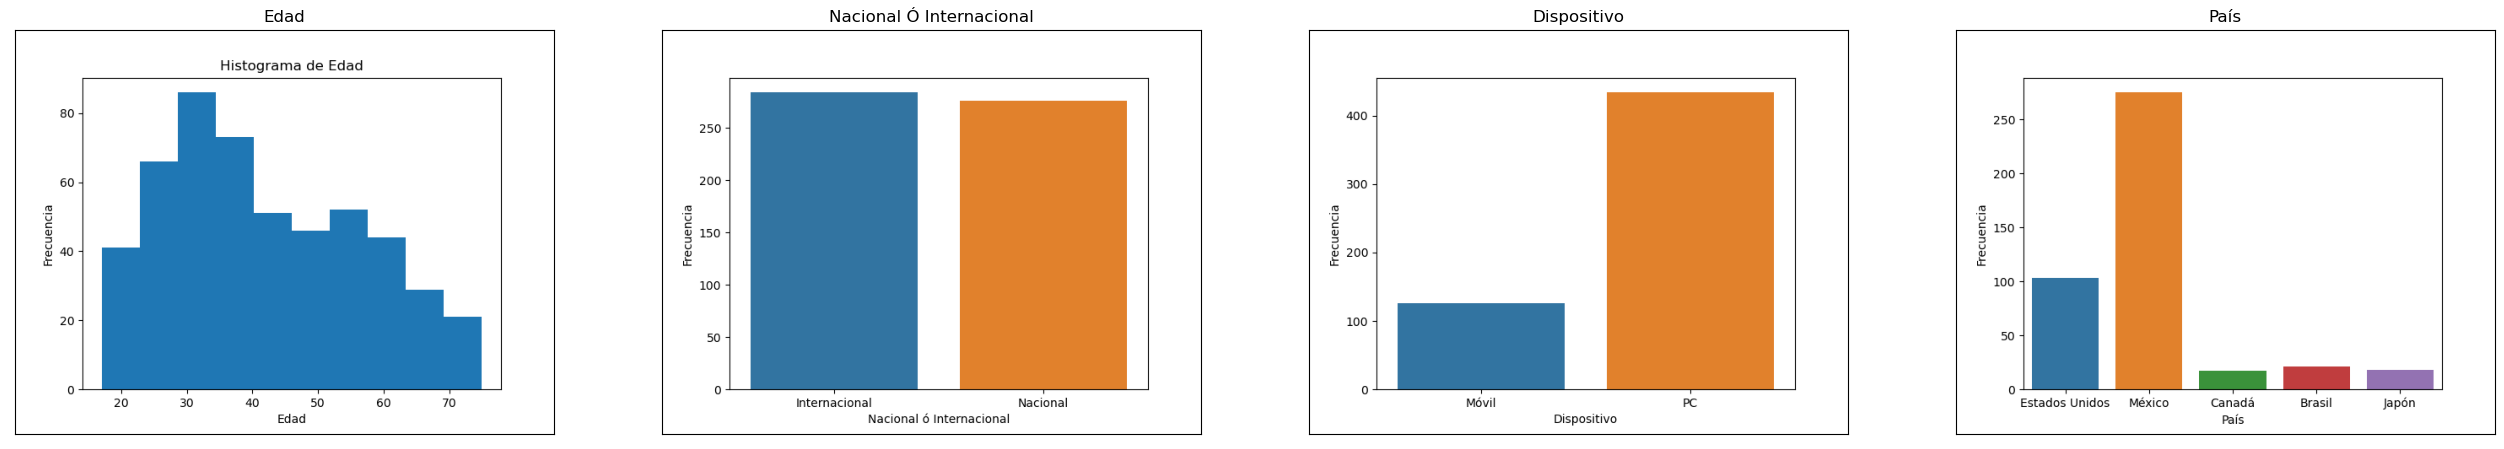

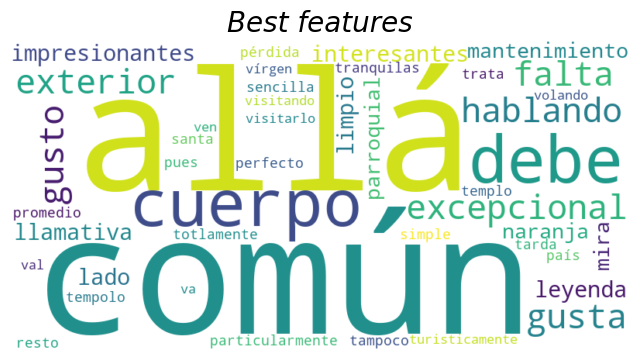

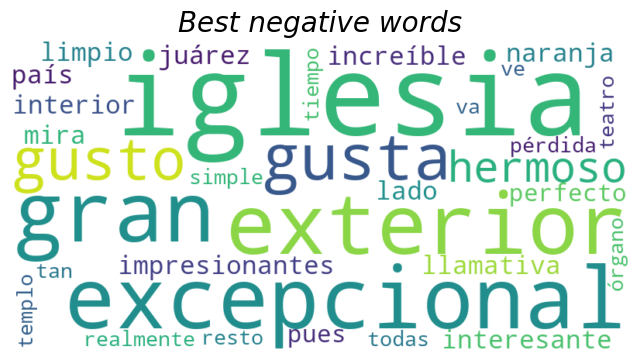

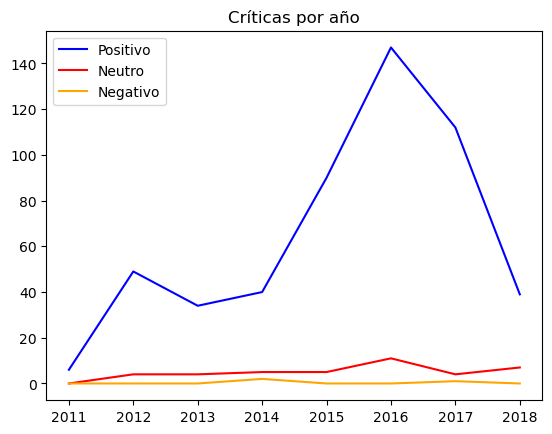

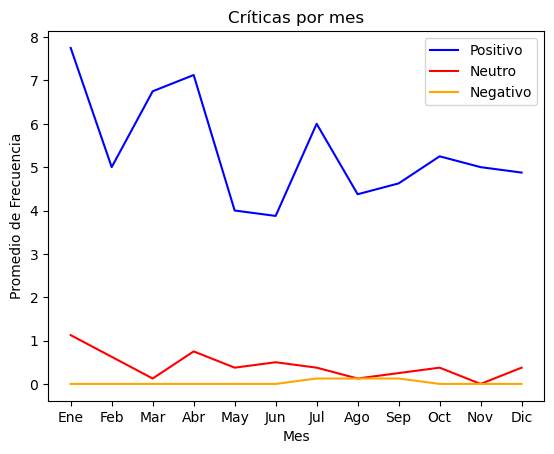

Hombres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 556 
 0.276663 
 ciudad 
 
 
 1404 
 0.273786 
 guanajuato 
 
 
 1496 
 0.222138 
 iglesia 
 
 
 1444 
 0.212626 
 hermosa 
 
 
 326 
 0.208119 
 basílica 
 
 
 524 
 0.204756 
 centro 
 
 
 1971 
 0.186470 
 noche 
 
 
 1728 
 0.169205 
 lugar 
 
 
 866 
 0.161311 
 dentro 
 
 
 222 
 0.135588 
 arquitectura 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2148 
 0.418585 
 pena 
 
 
 2907 
 0.418087 
 vale 
 
 
 1971 
 -0.270496 
 noche 
 
 
 2631 
 0.187093 
 si 
 
 
 998 
 -0.151005 
 día 
 
 
 1444 
 -0.149160 
 hermosa 
 
 
 369 
 0.143795 
 bonita 
 
 
 360 
 0.143297 
 bien 
 
 
 1496 
 -0.142334 
 iglesia 
 
 
 2998 
 0.139253 
 visitar 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 369 
 0.381409 
 bonita 
 
 
 1444 
 0.276785 
 hermosa 
 
 
 1728 
 -0.263530 
 lugar 
 
 
 866 
 0.250848 
 dentro 
 
 
 1971 
 0.244016 
 noche 
 
 
 1449 
 -0.229121 
 hermoso 
 
 
 1404 
 -0.215481 
 guanajuato 
 
 
 2988 
 -0.176310 
 visita 
 
 
 2007 
 -0.156923 
 obligada 
 
 
 2999 
 0.136202 
 visitarla

Mujeres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 556 
 0.276701 
 ciudad 
 
 
 1404 
 0.273783 
 guanajuato 
 
 
 1496 
 0.222116 
 iglesia 
 
 
 1444 
 0.212578 
 hermosa 
 
 
 326 
 0.208129 
 basílica 
 
 
 524 
 0.204724 
 centro 
 
 
 1971 
 0.186494 
 noche 
 
 
 1728 
 0.169198 
 lugar 
 
 
 866 
 0.161294 
 dentro 
 
 
 222 
 0.135546 
 arquitectura 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2148 
 0.413645 
 pena 
 
 
 2907 
 0.412828 
 vale 
 
 
 1971 
 -0.252663 
 noche 
 
 
 2631 
 0.193138 
 si 
 
 
 369 
 0.151234 
 bonita 
 
 
 360 
 0.143994 
 bien 
 
 
 2998 
 0.142620 
 visitar 
 
 
 998 
 -0.136628 
 día 
 
 
 1497 
 0.135580 
 iglesias 
 
 
 1383 
 -0.130524 
 gran 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 369 
 -0.385095 
 bonita 
 
 
 866 
 -0.254260 
 dentro 
 
 
 1728 
 0.250916 
 lugar 
 
 
 1449 
 0.246114 
 hermoso 
 
 
 1444 
 -0.244140 
 hermosa 
 
 
 1971 
 -0.235533 
 noche 
 
 
 1404 
 0.216230 
 guanajuato 
 
 
 2988 
 0.200136 
 visita 
 
 
 2007 
 0.176118 
 obligada 
 
 
 1497 
 0.149171 
 iglesias

Turistas Nacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 556 
 0.276679 
 ciudad 
 
 
 1404 
 0.273773 
 guanajuato 
 
 
 1496 
 0.222123 
 iglesia 
 
 
 1444 
 0.212560 
 hermosa 
 
 
 326 
 0.208146 
 basílica 
 
 
 524 
 0.204741 
 centro 
 
 
 1971 
 0.186515 
 noche 
 
 
 1728 
 0.169203 
 lugar 
 
 
 866 
 0.161279 
 dentro 
 
 
 222 
 0.135544 
 arquitectura 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2148 
 0.409066 
 pena 
 
 
 2907 
 0.408651 
 vale 
 
 
 1971 
 -0.305882 
 noche 
 
 
 2631 
 0.186708 
 si 
 
 
 1444 
 -0.158646 
 hermosa 
 
 
 998 
 -0.154753 
 día 
 
 
 1497 
 0.137770 
 iglesias 
 
 
 2998 
 0.136676 
 visitar 
 
 
 1496 
 -0.135006 
 iglesia 
 
 
 1505 
 -0.124946 
 iluminación 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 369 
 0.391732 
 bonita 
 
 
 1728 
 -0.289008 
 lugar 
 
 
 866 
 0.246648 
 dentro 
 
 
 1449 
 -0.239013 
 hermoso 
 
 
 1404 
 -0.232850 
 guanajuato 
 
 
 1971 
 0.228166 
 noche 
 
 
 1444 
 0.224786 
 hermosa 
 
 
 2988 
 -0.170849 
 visita 
 
 
 2007 
 -0.163230 
 obligada 
 
 
 2999 
 0.136047 
 visitarla

Turistas Internacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 556 
 0.276695 
 ciudad 
 
 
 1404 
 0.273774 
 guanajuato 
 
 
 1496 
 0.222132 
 iglesia 
 
 
 1444 
 0.212564 
 hermosa 
 
 
 326 
 0.208136 
 basílica 
 
 
 524 
 0.204732 
 centro 
 
 
 1971 
 0.186514 
 noche 
 
 
 1728 
 0.169186 
 lugar 
 
 
 866 
 0.161280 
 dentro 
 
 
 222 
 0.135539 
 arquitectura 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2907 
 0.432032 
 vale 
 
 
 2148 
 0.431953 
 pena 
 
 
 1971 
 -0.254689 
 noche 
 
 
 2631 
 0.192423 
 si 
 
 
 1496 
 -0.166664 
 iglesia 
 
 
 998 
 -0.141404 
 día 
 
 
 326 
 0.139196 
 basílica 
 
 
 2998 
 0.129308 
 visitar 
 
 
 1444 
 -0.125731 
 hermosa 
 
 
 1383 
 -0.115794 
 gran 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 369 
 0.399738 
 bonita 
 
 
 1728 
 -0.273658 
 lugar 
 
 
 866 
 0.242252 
 dentro 
 
 
 1444 
 0.235310 
 hermosa 
 
 
 1971 
 0.233854 
 noche 
 
 
 1449 
 -0.221873 
 hermoso 
 
 
 1404 
 -0.211792 
 guanajuato 
 
 
 2988 
 -0.197665 
 visita 
 
 
 2007 
 -0.175262 
 obligada 
 
 
 1497 
 -0.140116 
 iglesias

Personas Jovenes


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 556 
 0.276616 
 ciudad 
 
 
 1404 
 0.273793 
 guanajuato 
 
 
 1496 
 0.222150 
 iglesia 
 
 
 1444 
 0.212563 
 hermosa 
 
 
 326 
 0.208072 
 basílica 
 
 
 524 
 0.204728 
 centro 
 
 
 1971 
 0.186534 
 noche 
 
 
 1728 
 0.169226 
 lugar 
 
 
 866 
 0.161271 
 dentro 
 
 
 222 
 0.135544 
 arquitectura 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 1971 
 -0.374034 
 noche 
 
 
 2148 
 0.330356 
 pena 
 
 
 2907 
 0.329013 
 vale 
 
 
 1444 
 -0.219274 
 hermosa 
 
 
 2631 
 0.183986 
 si 
 
 
 1497 
 0.172831 
 iglesias 
 
 
 998 
 -0.169457 
 día 
 
 
 1505 
 -0.155942 
 iluminación 
 
 
 1404 
 0.152461 
 guanajuato 
 
 
 1496 
 -0.147559 
 iglesia 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 369 
 0.365862 
 bonita 
 
 
 1728 
 -0.340566 
 lugar 
 
 
 2907 
 0.249274 
 vale 
 
 
 2148 
 0.245560 
 pena 
 
 
 866 
 0.244844 
 dentro 
 
 
 1449 
 -0.233402 
 hermoso 
 
 
 1444 
 0.203719 
 hermosa 
 
 
 326 
 0.189620 
 basílica 
 
 
 1404 
 -0.188173 
 guanajuato 
 
 
 2007 
 -0.149799 
 obligada

Personas Mayor


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 556 
 0.276709 
 ciudad 
 
 
 1404 
 0.273740 
 guanajuato 
 
 
 1496 
 0.222126 
 iglesia 
 
 
 1444 
 0.212595 
 hermosa 
 
 
 326 
 0.208116 
 basílica 
 
 
 524 
 0.204734 
 centro 
 
 
 1971 
 0.186519 
 noche 
 
 
 1728 
 0.169181 
 lugar 
 
 
 866 
 0.161256 
 dentro 
 
 
 222 
 0.135549 
 arquitectura 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2148 
 0.394631 
 pena 
 
 
 2907 
 0.394269 
 vale 
 
 
 1971 
 -0.319065 
 noche 
 
 
 1444 
 -0.184565 
 hermosa 
 
 
 2631 
 0.184172 
 si 
 
 
 998 
 -0.154199 
 día 
 
 
 1497 
 0.146661 
 iglesias 
 
 
 360 
 0.134438 
 bien 
 
 
 2998 
 0.132798 
 visitar 
 
 
 1505 
 -0.130820 
 iluminación 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 369 
 0.398348 
 bonita 
 
 
 1728 
 -0.266353 
 lugar 
 
 
 866 
 0.247357 
 dentro 
 
 
 1971 
 0.220809 
 noche 
 
 
 1404 
 -0.200902 
 guanajuato 
 
 
 1449 
 -0.189369 
 hermoso 
 
 
 1444 
 0.179214 
 hermosa 
 
 
 2988 
 -0.174630 
 visita 
 
 
 326 
 0.169632 
 basílica 
 
 
 2007 
 -0.158703 
 obligada

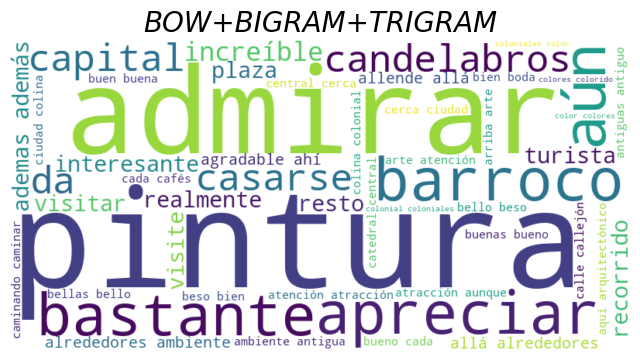

CallejóndelBeso
Promedio Puntaje:  4.0 Desviación Estandar: 0.97
Promedio Longitud 45.3 Desviación Estandar 32.84


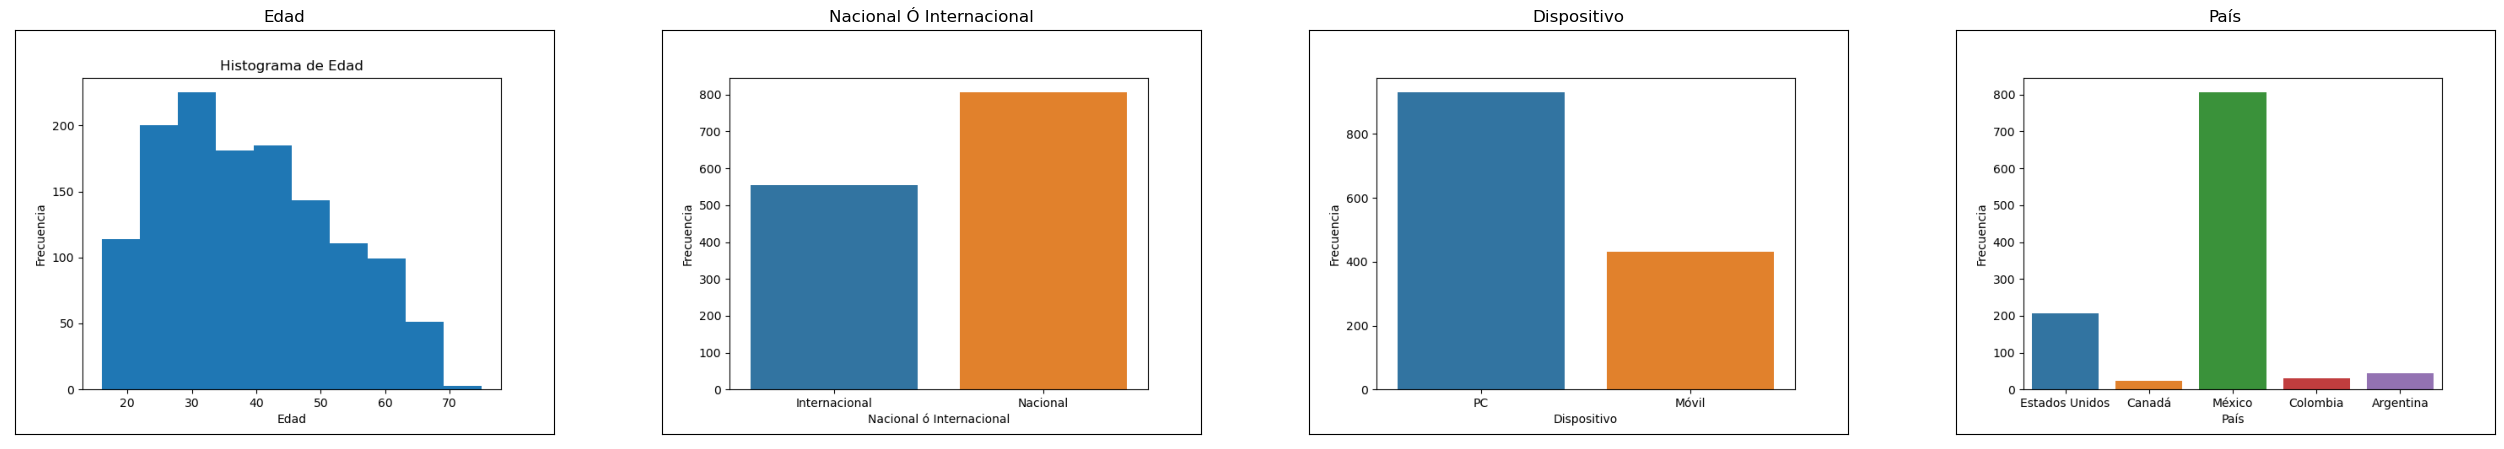

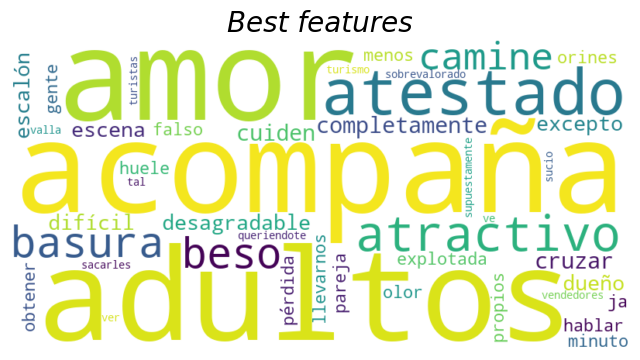

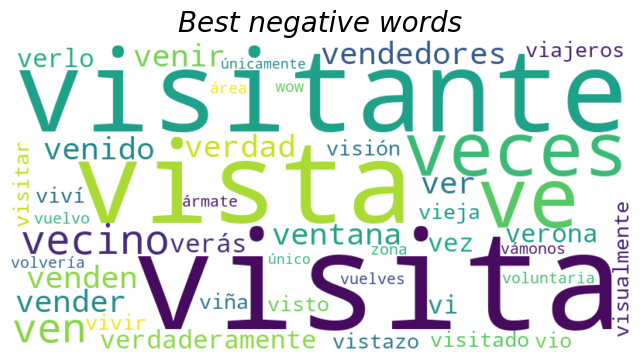

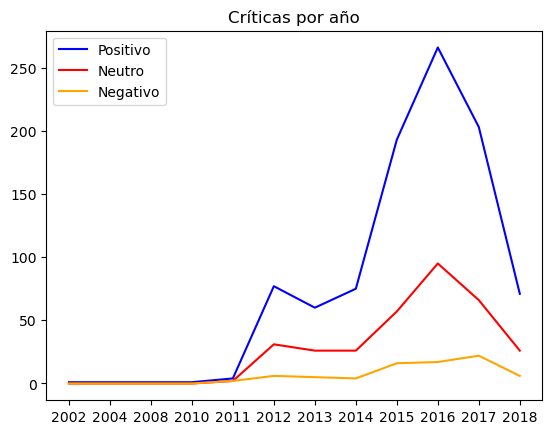

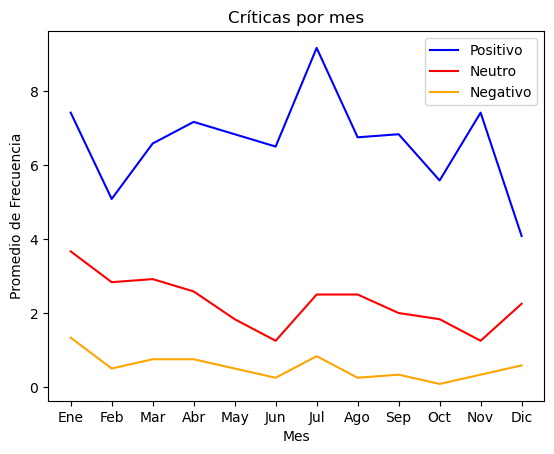

Hombres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2815 
 0.279214 
 lugar 
 
 
 747 
 0.267790 
 callejón 
 
 
 627 
 0.252685 
 beso 
 
 
 4278 
 0.235343 
 si 
 
 
 2289 
 0.213759 
 guanajuato 
 
 
 2387 
 0.211169 
 historia 
 
 
 3366 
 0.191881 
 pareja 
 
 
 2705 
 0.176682 
 leyenda 
 
 
 2180 
 0.176013 
 foto 
 
 
 2615 
 0.147997 
 ir 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2815 
 0.447695 
 lugar 
 
 
 627 
 -0.308541 
 beso 
 
 
 4892 
 0.294027 
 visitar 
 
 
 747 
 -0.271879 
 callejón 
 
 
 1891 
 -0.201205 
 escalón 
 
 
 2241 
 0.195210 
 gente 
 
 
 4407 
 -0.192523 
 suerte 
 
 
 4505 
 -0.182711 
 tercer 
 
 
 534 
 -0.147674 
 años 
 
 
 294 
 -0.127254 
 amor 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4778 
 0.293171 
 vas 
 
 
 4278 
 0.245426 
 si 
 
 
 2180 
 -0.224815 
 foto 
 
 
 3366 
 0.220046 
 pareja 
 
 
 627 
 0.191379 
 beso 
 
 
 557 
 -0.189576 
 balcón 
 
 
 2241 
 -0.186190 
 gente 
 
 
 2289 
 0.167927 
 guanajuato 
 
 
 4892 
 0.165593 
 visitar 
 
 
 4339 
 -0.150186 
 solo

Mujeres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2815 
 0.279212 
 lugar 
 
 
 747 
 0.267790 
 callejón 
 
 
 627 
 0.252687 
 beso 
 
 
 4278 
 0.235333 
 si 
 
 
 2289 
 0.213759 
 guanajuato 
 
 
 2387 
 0.211173 
 historia 
 
 
 3366 
 0.191884 
 pareja 
 
 
 2705 
 0.176686 
 leyenda 
 
 
 2180 
 0.176018 
 foto 
 
 
 2615 
 0.147988 
 ir 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2815 
 0.435419 
 lugar 
 
 
 627 
 -0.336858 
 beso 
 
 
 747 
 -0.286751 
 callejón 
 
 
 4892 
 0.243128 
 visitar 
 
 
 1891 
 -0.218572 
 escalón 
 
 
 2241 
 0.207017 
 gente 
 
 
 4505 
 -0.195349 
 tercer 
 
 
 4407 
 -0.186898 
 suerte 
 
 
 534 
 -0.144504 
 años 
 
 
 2705 
 -0.140672 
 leyenda 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4778 
 0.281436 
 vas 
 
 
 3366 
 0.226697 
 pareja 
 
 
 4278 
 0.217609 
 si 
 
 
 2180 
 -0.209791 
 foto 
 
 
 557 
 -0.195478 
 balcón 
 
 
 627 
 0.177887 
 beso 
 
 
 4892 
 0.175905 
 visitar 
 
 
 2815 
 0.175032 
 lugar 
 
 
 2289 
 0.173056 
 guanajuato 
 
 
 2241 
 -0.168781 
 gente

Turistas Nacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2815 
 0.279213 
 lugar 
 
 
 747 
 0.267790 
 callejón 
 
 
 627 
 0.252685 
 beso 
 
 
 4278 
 0.235337 
 si 
 
 
 2289 
 0.213760 
 guanajuato 
 
 
 2387 
 0.211169 
 historia 
 
 
 3366 
 0.191885 
 pareja 
 
 
 2705 
 0.176682 
 leyenda 
 
 
 2180 
 0.176017 
 foto 
 
 
 2615 
 0.147991 
 ir 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2815 
 0.427196 
 lugar 
 
 
 627 
 -0.347314 
 beso 
 
 
 747 
 -0.290568 
 callejón 
 
 
 4892 
 0.249796 
 visitar 
 
 
 1891 
 -0.213475 
 escalón 
 
 
 2241 
 0.206742 
 gente 
 
 
 4505 
 -0.191824 
 tercer 
 
 
 4407 
 -0.179946 
 suerte 
 
 
 2705 
 -0.142450 
 leyenda 
 
 
 534 
 -0.140083 
 años 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4778 
 0.282146 
 vas 
 
 
 4278 
 0.230567 
 si 
 
 
 3366 
 0.213898 
 pareja 
 
 
 2180 
 -0.207135 
 foto 
 
 
 4892 
 0.187499 
 visitar 
 
 
 557 
 -0.187160 
 balcón 
 
 
 2289 
 0.173973 
 guanajuato 
 
 
 2241 
 -0.173434 
 gente 
 
 
 2815 
 0.173168 
 lugar 
 
 
 627 
 0.163040 
 beso

Turistas Internacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2815 
 0.279211 
 lugar 
 
 
 747 
 0.267790 
 callejón 
 
 
 627 
 0.252686 
 beso 
 
 
 4278 
 0.235336 
 si 
 
 
 2289 
 0.213760 
 guanajuato 
 
 
 2387 
 0.211169 
 historia 
 
 
 3366 
 0.191884 
 pareja 
 
 
 2705 
 0.176687 
 leyenda 
 
 
 2180 
 0.176014 
 foto 
 
 
 2615 
 0.147992 
 ir 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2815 
 0.435208 
 lugar 
 
 
 627 
 -0.336044 
 beso 
 
 
 747 
 -0.287896 
 callejón 
 
 
 4892 
 0.238348 
 visitar 
 
 
 1891 
 -0.219180 
 escalón 
 
 
 2241 
 0.213194 
 gente 
 
 
 4505 
 -0.198436 
 tercer 
 
 
 4407 
 -0.182353 
 suerte 
 
 
 294 
 -0.143912 
 amor 
 
 
 534 
 -0.140932 
 años 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4778 
 0.282035 
 vas 
 
 
 3366 
 0.225078 
 pareja 
 
 
 4278 
 0.219719 
 si 
 
 
 2180 
 -0.207804 
 foto 
 
 
 557 
 -0.189926 
 balcón 
 
 
 2241 
 -0.188353 
 gente 
 
 
 627 
 0.188132 
 beso 
 
 
 4892 
 0.182262 
 visitar 
 
 
 2815 
 0.175383 
 lugar 
 
 
 2289 
 0.171673 
 guanajuato

Personas Jovenes


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2815 
 0.279212 
 lugar 
 
 
 747 
 0.267798 
 callejón 
 
 
 627 
 0.252690 
 beso 
 
 
 4278 
 0.235339 
 si 
 
 
 2289 
 0.213760 
 guanajuato 
 
 
 2387 
 0.211166 
 historia 
 
 
 3366 
 0.191883 
 pareja 
 
 
 2705 
 0.176680 
 leyenda 
 
 
 2180 
 0.176012 
 foto 
 
 
 2615 
 0.147997 
 ir 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2815 
 0.458386 
 lugar 
 
 
 627 
 -0.317004 
 beso 
 
 
 747 
 -0.270398 
 callejón 
 
 
 4892 
 0.259730 
 visitar 
 
 
 1891 
 -0.216446 
 escalón 
 
 
 2241 
 0.196239 
 gente 
 
 
 4505 
 -0.191185 
 tercer 
 
 
 4407 
 -0.188356 
 suerte 
 
 
 534 
 -0.144749 
 años 
 
 
 294 
 -0.144036 
 amor 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4778 
 0.277441 
 vas 
 
 
 3366 
 0.227181 
 pareja 
 
 
 2180 
 -0.227068 
 foto 
 
 
 4278 
 0.225813 
 si 
 
 
 2241 
 -0.184894 
 gente 
 
 
 557 
 -0.183675 
 balcón 
 
 
 627 
 0.175210 
 beso 
 
 
 2289 
 0.174719 
 guanajuato 
 
 
 4892 
 0.174049 
 visitar 
 
 
 4339 
 -0.150262 
 solo

Personas Mayor


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2815 
 0.279211 
 lugar 
 
 
 747 
 0.267795 
 callejón 
 
 
 627 
 0.252690 
 beso 
 
 
 4278 
 0.235329 
 si 
 
 
 2289 
 0.213764 
 guanajuato 
 
 
 2387 
 0.211170 
 historia 
 
 
 3366 
 0.191880 
 pareja 
 
 
 2705 
 0.176684 
 leyenda 
 
 
 2180 
 0.176016 
 foto 
 
 
 2615 
 0.147991 
 ir 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2815 
 -0.395529 
 lugar 
 
 
 627 
 0.346314 
 beso 
 
 
 747 
 0.247900 
 callejón 
 
 
 4892 
 -0.234756 
 visitar 
 
 
 2241 
 -0.229871 
 gente 
 
 
 1891 
 0.229002 
 escalón 
 
 
 4407 
 0.208056 
 suerte 
 
 
 4505 
 0.204834 
 tercer 
 
 
 534 
 0.159477 
 años 
 
 
 2705 
 0.132591 
 leyenda 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4778 
 0.258259 
 vas 
 
 
 2289 
 0.227684 
 guanajuato 
 
 
 4892 
 0.214719 
 visitar 
 
 
 2180 
 -0.206863 
 foto 
 
 
 2815 
 0.206193 
 lugar 
 
 
 3366 
 0.198286 
 pareja 
 
 
 557 
 -0.176338 
 balcón 
 
 
 4278 
 0.172376 
 si 
 
 
 627 
 0.165701 
 beso 
 
 
 2241 
 -0.153082 
 gente

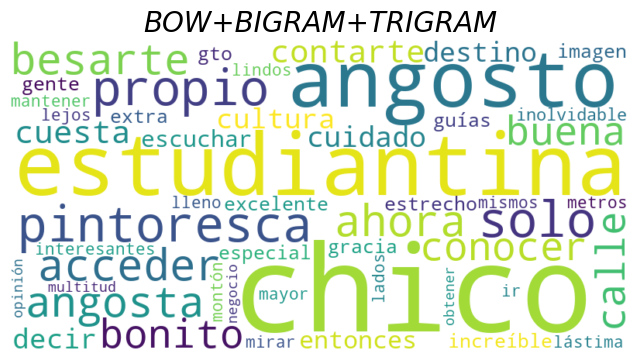

CasadeDiegoRivera
Promedio Puntaje:  4.24 Desviación Estandar: 0.8
Promedio Longitud 49.89 Desviación Estandar 30.89


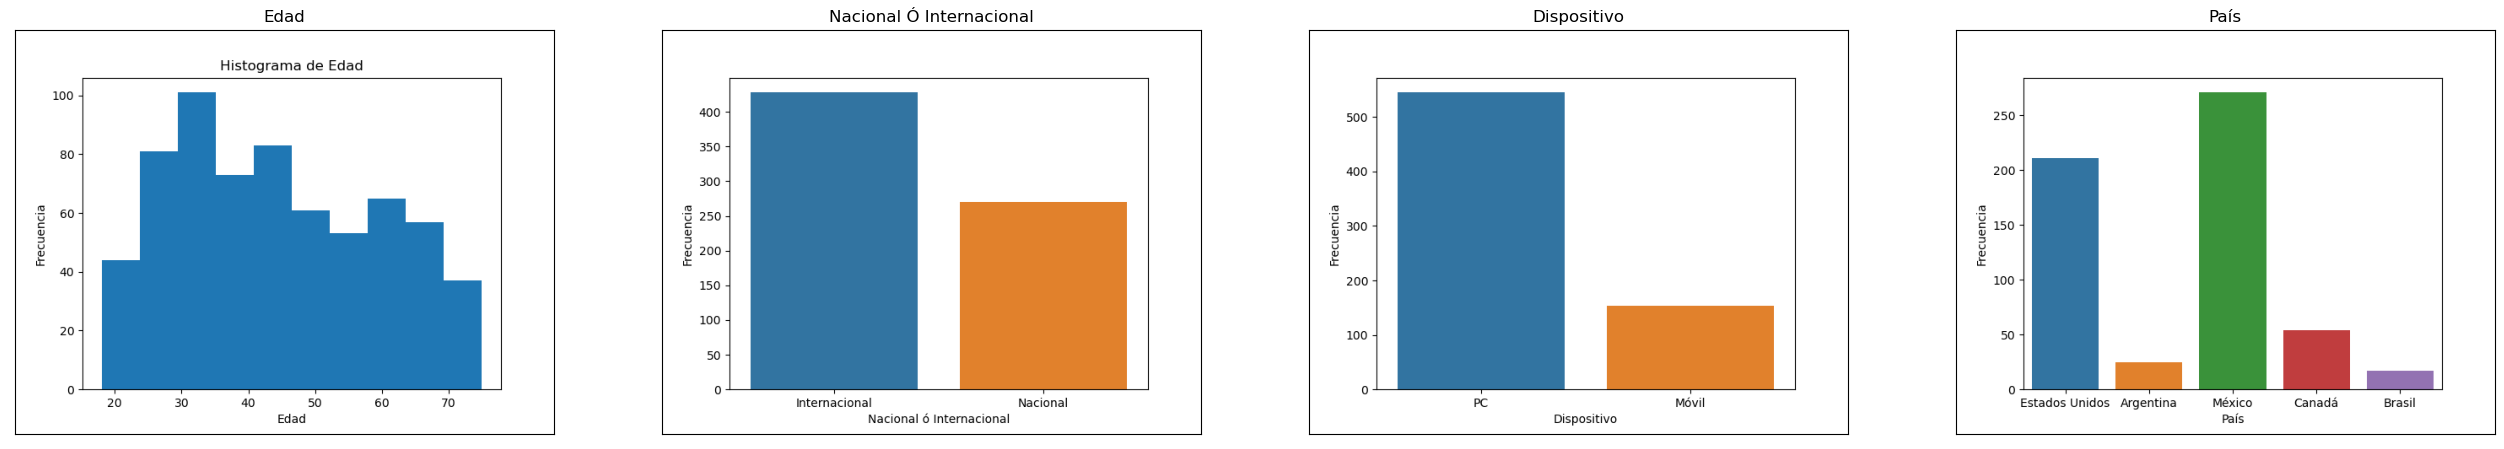

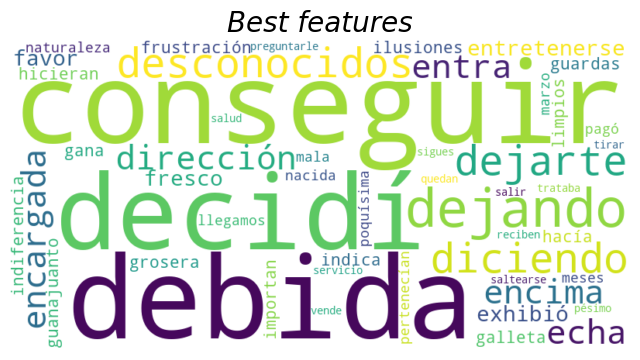

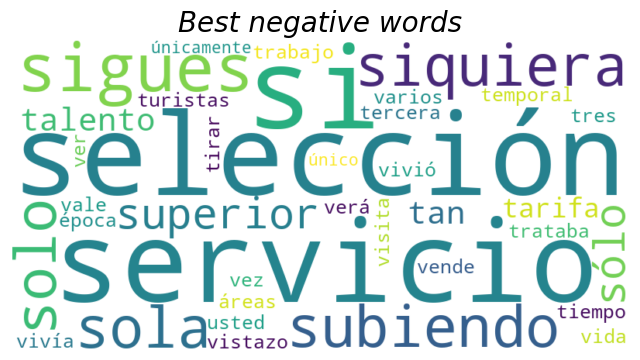

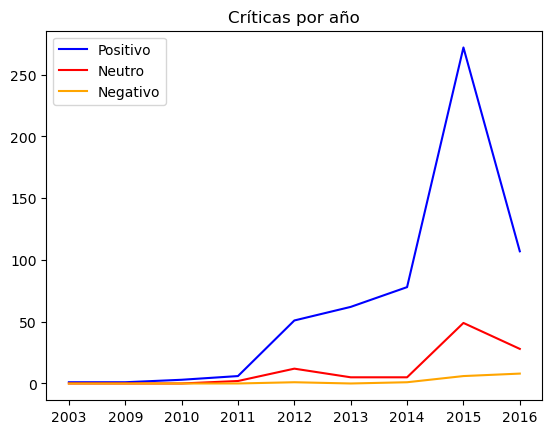

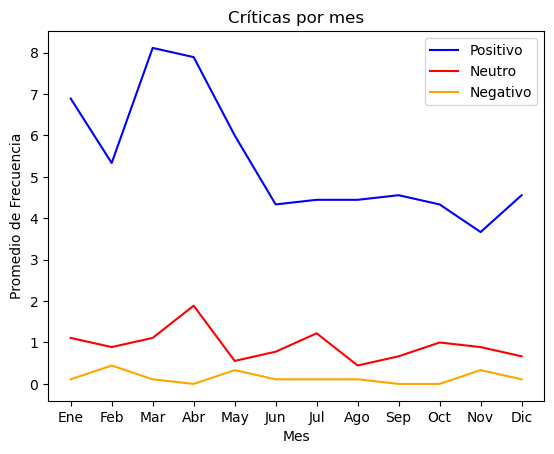

Hombres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1065 
 0.292241 
 diego 
 
 
 2999 
 0.287092 
 rivera 
 
 
 547 
 0.270459 
 casa 
 
 
 2268 
 0.241695 
 museo 
 
 
 2351 
 0.212172 
 obras 
 
 
 333 
 0.207458 
 arte 
 
 
 3449 
 0.158809 
 ver 
 
 
 339 
 0.138018 
 artistas 
 
 
 1922 
 0.129180 
 interesante 
 
 
 2066 
 0.126477 
 lugar 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2489 
 0.391984 
 pena 
 
 
 3410 
 0.385210 
 vale 
 
 
 3449 
 0.229179 
 ver 
 
 
 2570 
 -0.194267 
 pintor 
 
 
 3492 
 0.154880 
 visita 
 
 
 2829 
 0.151128 
 realmente 
 
 
 2066 
 -0.144946 
 lugar 
 
 
 547 
 -0.142561 
 casa 
 
 
 701 
 -0.137717 
 conocer 
 
 
 3532 
 -0.135374 
 vivió 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2066 
 0.377637 
 lugar 
 
 
 3449 
 -0.272080 
 ver 
 
 
 414 
 -0.214613 
 años 
 
 
 3410 
 0.210292 
 vale 
 
 
 2489 
 0.201801 
 pena 
 
 
 3500 
 0.164201 
 visitar 
 
 
 2693 
 -0.163151 
 primeros 
 
 
 701 
 0.161285 
 conocer 
 
 
 3105 
 0.160380 
 si 
 
 
 1397 
 0.152493 
 excelente

Mujeres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1065 
 0.292240 
 diego 
 
 
 2999 
 0.287092 
 rivera 
 
 
 547 
 0.270458 
 casa 
 
 
 2268 
 0.241696 
 museo 
 
 
 2351 
 0.212176 
 obras 
 
 
 333 
 0.207459 
 arte 
 
 
 3449 
 0.158812 
 ver 
 
 
 339 
 0.138015 
 artistas 
 
 
 1922 
 0.129179 
 interesante 
 
 
 2066 
 0.126476 
 lugar 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2489 
 0.418199 
 pena 
 
 
 3410 
 0.412321 
 vale 
 
 
 2351 
 -0.233164 
 obras 
 
 
 3449 
 0.211794 
 ver 
 
 
 2570 
 -0.186920 
 pintor 
 
 
 701 
 -0.140278 
 conocer 
 
 
 1065 
 -0.135331 
 diego 
 
 
 3156 
 0.129249 
 solo 
 
 
 2829 
 0.118765 
 realmente 
 
 
 547 
 -0.115412 
 casa 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2066 
 0.350105 
 lugar 
 
 
 3449 
 -0.259939 
 ver 
 
 
 3410 
 0.255657 
 vale 
 
 
 2489 
 0.247846 
 pena 
 
 
 414 
 -0.223636 
 años 
 
 
 2693 
 -0.181706 
 primeros 
 
 
 701 
 0.164028 
 conocer 
 
 
 3500 
 0.163163 
 visitar 
 
 
 319 
 -0.148400 
 aquí 
 
 
 1922 
 -0.130660 
 interesante

Turistas Nacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1065 
 0.292239 
 diego 
 
 
 2999 
 0.287091 
 rivera 
 
 
 547 
 0.270458 
 casa 
 
 
 2268 
 0.241698 
 museo 
 
 
 2351 
 0.212176 
 obras 
 
 
 333 
 0.207459 
 arte 
 
 
 3449 
 0.158814 
 ver 
 
 
 339 
 0.138014 
 artistas 
 
 
 1922 
 0.129180 
 interesante 
 
 
 2066 
 0.126476 
 lugar 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2489 
 0.433495 
 pena 
 
 
 3410 
 0.429410 
 vale 
 
 
 2351 
 -0.221756 
 obras 
 
 
 3449 
 0.201521 
 ver 
 
 
 2570 
 -0.171686 
 pintor 
 
 
 3313 
 0.143897 
 trabajo 
 
 
 1450 
 -0.143538 
 exposiciones 
 
 
 3156 
 0.128257 
 solo 
 
 
 701 
 -0.117761 
 conocer 
 
 
 2553 
 0.114438 
 pesos 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2066 
 -0.340842 
 lugar 
 
 
 414 
 0.243679 
 años 
 
 
 3410 
 -0.241360 
 vale 
 
 
 2489 
 -0.234016 
 pena 
 
 
 3449 
 0.233283 
 ver 
 
 
 2693 
 0.192709 
 primeros 
 
 
 3500 
 -0.166513 
 visitar 
 
 
 319 
 0.161787 
 aquí 
 
 
 450 
 -0.160062 
 bien 
 
 
 701 
 -0.158375 
 conocer

Turistas Internacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1065 
 0.292244 
 diego 
 
 
 2999 
 0.287095 
 rivera 
 
 
 547 
 0.270460 
 casa 
 
 
 2268 
 0.241700 
 museo 
 
 
 2351 
 0.212176 
 obras 
 
 
 333 
 0.207458 
 arte 
 
 
 3449 
 0.158815 
 ver 
 
 
 339 
 0.138014 
 artistas 
 
 
 1922 
 0.129184 
 interesante 
 
 
 2066 
 0.126477 
 lugar 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2489 
 0.416429 
 pena 
 
 
 3410 
 0.409452 
 vale 
 
 
 2351 
 -0.236915 
 obras 
 
 
 3449 
 0.213549 
 ver 
 
 
 2570 
 -0.199092 
 pintor 
 
 
 1450 
 -0.128243 
 exposiciones 
 
 
 701 
 -0.123998 
 conocer 
 
 
 3156 
 0.122802 
 solo 
 
 
 3313 
 0.120888 
 trabajo 
 
 
 3492 
 0.118480 
 visita 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2066 
 0.364087 
 lugar 
 
 
 414 
 -0.239412 
 años 
 
 
 3410 
 0.232179 
 vale 
 
 
 2489 
 0.222992 
 pena 
 
 
 3449 
 -0.216345 
 ver 
 
 
 450 
 0.187729 
 bien 
 
 
 547 
 -0.184459 
 casa 
 
 
 2693 
 -0.176861 
 primeros 
 
 
 3492 
 0.171177 
 visita 
 
 
 3500 
 0.151355 
 visitar

Personas Jovenes


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1065 
 0.292243 
 diego 
 
 
 2999 
 0.287093 
 rivera 
 
 
 547 
 0.270458 
 casa 
 
 
 2268 
 0.241699 
 museo 
 
 
 2351 
 0.212176 
 obras 
 
 
 333 
 0.207455 
 arte 
 
 
 3449 
 0.158814 
 ver 
 
 
 339 
 0.138014 
 artistas 
 
 
 1922 
 0.129180 
 interesante 
 
 
 2066 
 0.126473 
 lugar 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2489 
 0.424200 
 pena 
 
 
 3410 
 0.419243 
 vale 
 
 
 2351 
 -0.248170 
 obras 
 
 
 3449 
 0.214824 
 ver 
 
 
 2570 
 -0.179867 
 pintor 
 
 
 3313 
 0.153387 
 trabajo 
 
 
 1450 
 -0.139340 
 exposiciones 
 
 
 3156 
 0.129364 
 solo 
 
 
 1065 
 -0.117912 
 diego 
 
 
 2553 
 0.113028 
 pesos 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2066 
 0.342823 
 lugar 
 
 
 414 
 -0.246484 
 años 
 
 
 3449 
 -0.244630 
 ver 
 
 
 3410 
 0.217187 
 vale 
 
 
 2489 
 0.208726 
 pena 
 
 
 450 
 0.204202 
 bien 
 
 
 547 
 -0.183143 
 casa 
 
 
 2693 
 -0.171351 
 primeros 
 
 
 3492 
 0.155988 
 visita 
 
 
 3500 
 0.138523 
 visitar

Personas Mayor


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1065 
 0.292242 
 diego 
 
 
 2999 
 0.287092 
 rivera 
 
 
 547 
 0.270457 
 casa 
 
 
 2268 
 0.241696 
 museo 
 
 
 2351 
 0.212175 
 obras 
 
 
 333 
 0.207457 
 arte 
 
 
 3449 
 0.158812 
 ver 
 
 
 339 
 0.138017 
 artistas 
 
 
 1922 
 0.129181 
 interesante 
 
 
 2066 
 0.126476 
 lugar 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2489 
 0.419576 
 pena 
 
 
 3410 
 0.419018 
 vale 
 
 
 2351 
 -0.253791 
 obras 
 
 
 3449 
 0.227734 
 ver 
 
 
 2570 
 -0.172487 
 pintor 
 
 
 3156 
 0.147975 
 solo 
 
 
 701 
 -0.135340 
 conocer 
 
 
 3313 
 0.131073 
 trabajo 
 
 
 1065 
 -0.128477 
 diego 
 
 
 1450 
 -0.115350 
 exposiciones 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2066 
 0.388376 
 lugar 
 
 
 3410 
 0.303205 
 vale 
 
 
 2489 
 0.288452 
 pena 
 
 
 3449 
 -0.251535 
 ver 
 
 
 701 
 0.167595 
 conocer 
 
 
 333 
 -0.166526 
 arte 
 
 
 1397 
 0.158378 
 excelente 
 
 
 3500 
 0.152583 
 visitar 
 
 
 450 
 0.147194 
 bien 
 
 
 414 
 -0.146257 
 años

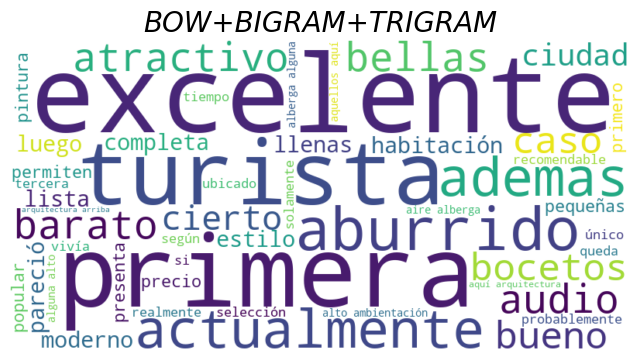

JardíndelaUnión
Promedio Puntaje:  4.59 Desviación Estandar: 0.61
Promedio Longitud 43.91 Desviación Estandar 37.31


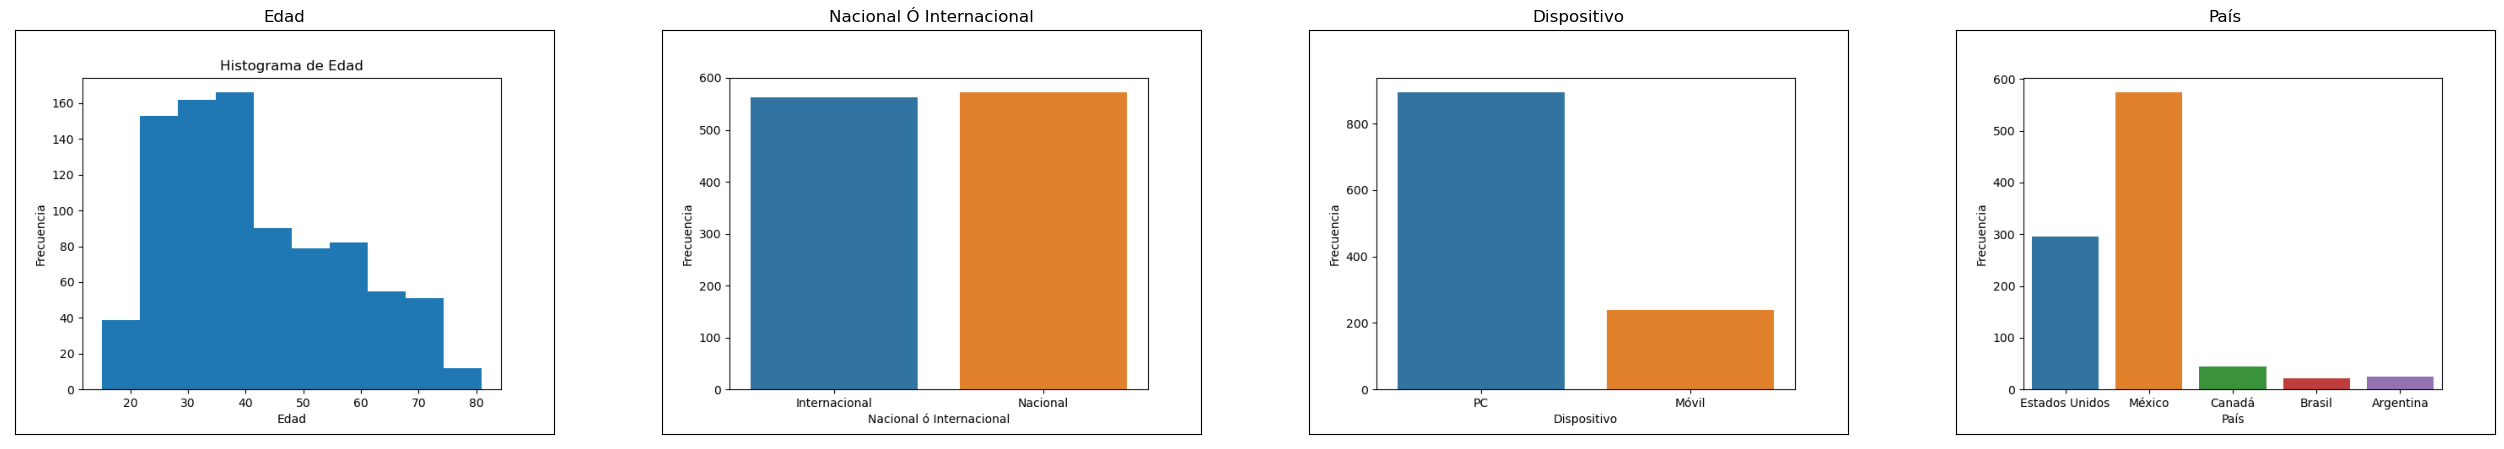

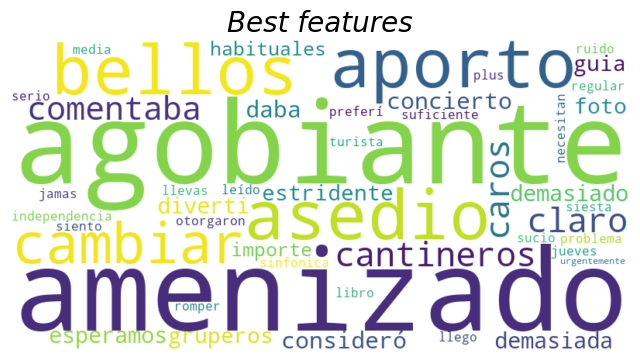

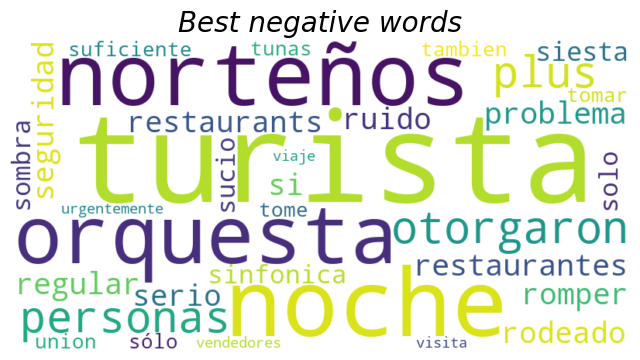

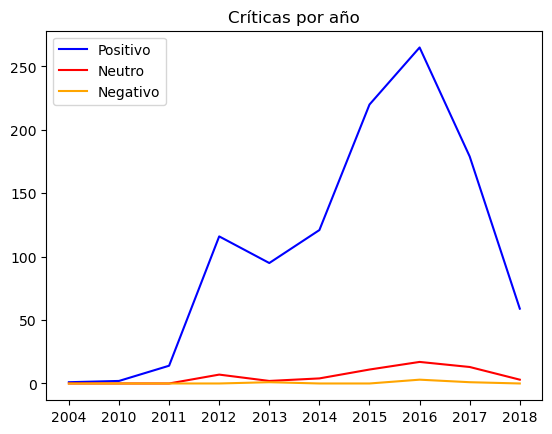

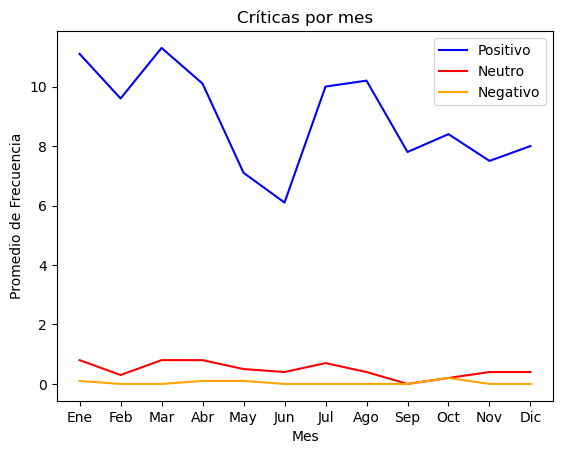

Hombres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2484 
 0.295910 
 lugar 
 
 
 3543 
 0.239937 
 restaurantes 
 
 
 2314 
 0.201913 
 jardín 
 
 
 1965 
 0.190307 
 gente 
 
 
 2014 
 0.170428 
 guanajuato 
 
 
 2719 
 0.170137 
 música 
 
 
 3943 
 0.164351 
 teatro 
 
 
 852 
 0.154885 
 ciudad 
 
 
 3130 
 0.151452 
 plaza 
 
 
 2765 
 0.142931 
 noche 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 3943 
 -0.317216 
 teatro 
 
 
 2350 
 -0.235539 
 juárez 
 
 
 2484 
 0.232030 
 lugar 
 
 
 1901 
 -0.227832 
 frente 
 
 
 2971 
 0.199413 
 pasar 
 
 
 2719 
 0.173935 
 música 
 
 
 794 
 -0.172835 
 centro 
 
 
 1965 
 0.169777 
 gente 
 
 
 2314 
 -0.167334 
 jardín 
 
 
 2014 
 -0.149986 
 guanajuato 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 3130 
 0.337745 
 plaza 
 
 
 2815 
 0.238982 
 observar 
 
 
 1965 
 0.233793 
 gente 
 
 
 610 
 -0.198160 
 buen 
 
 
 3943 
 -0.175732 
 teatro 
 
 
 913 
 -0.165506 
 comer 
 
 
 1988 
 0.163981 
 gran 
 
 
 4359 
 0.159439 
 árboles 
 
 
 585 
 -0.157998 
 bonito 
 
 
 3309 
 -0.142865 
 puedes

Mujeres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2484 
 0.295905 
 lugar 
 
 
 3543 
 0.239940 
 restaurantes 
 
 
 2314 
 0.201912 
 jardín 
 
 
 1965 
 0.190312 
 gente 
 
 
 2014 
 0.170425 
 guanajuato 
 
 
 2719 
 0.170139 
 música 
 
 
 3943 
 0.164351 
 teatro 
 
 
 852 
 0.154882 
 ciudad 
 
 
 3130 
 0.151454 
 plaza 
 
 
 2765 
 0.142935 
 noche 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 3943 
 -0.321812 
 teatro 
 
 
 2350 
 -0.235070 
 juárez 
 
 
 2484 
 0.234529 
 lugar 
 
 
 1901 
 -0.228846 
 frente 
 
 
 2971 
 0.201931 
 pasar 
 
 
 1965 
 0.170728 
 gente 
 
 
 2314 
 -0.166920 
 jardín 
 
 
 2719 
 0.165802 
 música 
 
 
 794 
 -0.158973 
 centro 
 
 
 610 
 0.145643 
 buen 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 3130 
 0.360694 
 plaza 
 
 
 1965 
 0.237818 
 gente 
 
 
 2815 
 0.229633 
 observar 
 
 
 610 
 -0.178115 
 buen 
 
 
 3943 
 -0.172815 
 teatro 
 
 
 585 
 -0.166586 
 bonito 
 
 
 913 
 -0.166057 
 comer 
 
 
 2484 
 -0.162330 
 lugar 
 
 
 1988 
 0.154671 
 gran 
 
 
 3309 
 -0.149666 
 puedes

Turistas Nacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2484 
 0.295906 
 lugar 
 
 
 3543 
 0.239937 
 restaurantes 
 
 
 2314 
 0.201915 
 jardín 
 
 
 1965 
 0.190312 
 gente 
 
 
 2014 
 0.170427 
 guanajuato 
 
 
 2719 
 0.170143 
 música 
 
 
 3943 
 0.164352 
 teatro 
 
 
 852 
 0.154887 
 ciudad 
 
 
 3130 
 0.151448 
 plaza 
 
 
 2765 
 0.142932 
 noche 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 3943 
 -0.325114 
 teatro 
 
 
 2350 
 -0.239356 
 juárez 
 
 
 2484 
 0.231027 
 lugar 
 
 
 1901 
 -0.226432 
 frente 
 
 
 2971 
 0.207062 
 pasar 
 
 
 1965 
 0.173245 
 gente 
 
 
 2719 
 0.171137 
 música 
 
 
 794 
 -0.166909 
 centro 
 
 
 610 
 0.158296 
 buen 
 
 
 2314 
 -0.157284 
 jardín 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 3130 
 0.324924 
 plaza 
 
 
 1965 
 0.245263 
 gente 
 
 
 2815 
 0.244472 
 observar 
 
 
 610 
 -0.205786 
 buen 
 
 
 913 
 -0.172416 
 comer 
 
 
 3943 
 -0.169041 
 teatro 
 
 
 1988 
 0.163559 
 gran 
 
 
 4359 
 0.151527 
 árboles 
 
 
 254 
 -0.151184 
 ambiente 
 
 
 3309 
 -0.150162 
 puedes

Turistas Internacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2484 
 0.295908 
 lugar 
 
 
 3543 
 0.239937 
 restaurantes 
 
 
 2314 
 0.201914 
 jardín 
 
 
 1965 
 0.190308 
 gente 
 
 
 2014 
 0.170424 
 guanajuato 
 
 
 2719 
 0.170141 
 música 
 
 
 3943 
 0.164352 
 teatro 
 
 
 852 
 0.154888 
 ciudad 
 
 
 3130 
 0.151451 
 plaza 
 
 
 2765 
 0.142933 
 noche 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 3943 
 -0.324756 
 teatro 
 
 
 2350 
 -0.238300 
 juárez 
 
 
 2484 
 0.238086 
 lugar 
 
 
 1901 
 -0.226242 
 frente 
 
 
 2971 
 0.197798 
 pasar 
 
 
 1965 
 0.169178 
 gente 
 
 
 794 
 -0.167815 
 centro 
 
 
 2314 
 -0.162466 
 jardín 
 
 
 2719 
 0.162032 
 música 
 
 
 610 
 0.155420 
 buen 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 3130 
 0.352235 
 plaza 
 
 
 1965 
 0.229031 
 gente 
 
 
 2815 
 0.228418 
 observar 
 
 
 3943 
 -0.187115 
 teatro 
 
 
 610 
 -0.176053 
 buen 
 
 
 913 
 -0.169472 
 comer 
 
 
 4359 
 0.161522 
 árboles 
 
 
 1988 
 0.159996 
 gran 
 
 
 3309 
 -0.154930 
 puedes 
 
 
 585 
 -0.145676 
 bonito

Personas Jovenes


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2484 
 0.295907 
 lugar 
 
 
 3543 
 0.239937 
 restaurantes 
 
 
 2314 
 0.201917 
 jardín 
 
 
 1965 
 0.190307 
 gente 
 
 
 2014 
 0.170427 
 guanajuato 
 
 
 2719 
 0.170138 
 música 
 
 
 3943 
 0.164351 
 teatro 
 
 
 852 
 0.154888 
 ciudad 
 
 
 3130 
 0.151452 
 plaza 
 
 
 2765 
 0.142932 
 noche 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 3943 
 -0.322232 
 teatro 
 
 
 2484 
 0.240731 
 lugar 
 
 
 2350 
 -0.236861 
 juárez 
 
 
 1901 
 -0.219560 
 frente 
 
 
 2971 
 0.196496 
 pasar 
 
 
 1965 
 0.169955 
 gente 
 
 
 2719 
 0.168099 
 música 
 
 
 2314 
 -0.164659 
 jardín 
 
 
 794 
 -0.161063 
 centro 
 
 
 610 
 0.155037 
 buen 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 3130 
 0.351655 
 plaza 
 
 
 1965 
 0.236468 
 gente 
 
 
 2815 
 0.233730 
 observar 
 
 
 3943 
 -0.179076 
 teatro 
 
 
 610 
 -0.173358 
 buen 
 
 
 1988 
 0.163258 
 gran 
 
 
 913 
 -0.159475 
 comer 
 
 
 585 
 -0.158492 
 bonito 
 
 
 3309 
 -0.153678 
 puedes 
 
 
 4359 
 0.150746 
 árboles

Personas Mayor


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2484 
 0.295908 
 lugar 
 
 
 3543 
 0.239939 
 restaurantes 
 
 
 2314 
 0.201913 
 jardín 
 
 
 1965 
 0.190310 
 gente 
 
 
 2014 
 0.170426 
 guanajuato 
 
 
 2719 
 0.170143 
 música 
 
 
 3943 
 0.164353 
 teatro 
 
 
 852 
 0.154884 
 ciudad 
 
 
 3130 
 0.151450 
 plaza 
 
 
 2765 
 0.142934 
 noche 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 3943 
 -0.324798 
 teatro 
 
 
 2350 
 -0.237599 
 juárez 
 
 
 2484 
 0.235734 
 lugar 
 
 
 1901 
 -0.223581 
 frente 
 
 
 2971 
 0.200110 
 pasar 
 
 
 1965 
 0.169448 
 gente 
 
 
 794 
 -0.168656 
 centro 
 
 
 2719 
 0.165952 
 música 
 
 
 2314 
 -0.161054 
 jardín 
 
 
 610 
 0.153091 
 buen 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 3130 
 0.349350 
 plaza 
 
 
 2815 
 0.237966 
 observar 
 
 
 1965 
 0.235466 
 gente 
 
 
 610 
 -0.198533 
 buen 
 
 
 1988 
 0.173215 
 gran 
 
 
 3943 
 -0.166824 
 teatro 
 
 
 913 
 -0.162516 
 comer 
 
 
 4359 
 0.159419 
 árboles 
 
 
 3309 
 -0.154940 
 puedes 
 
 
 585 
 -0.149508 
 bonito

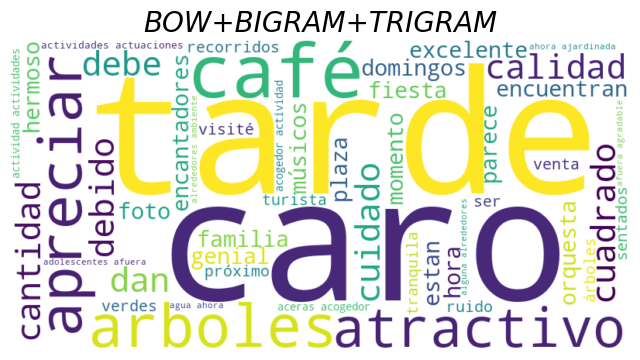

MercadoHidalgo
Promedio Puntaje:  3.95 Desviación Estandar: 0.95
Promedio Longitud 45.9 Desviación Estandar 33.96


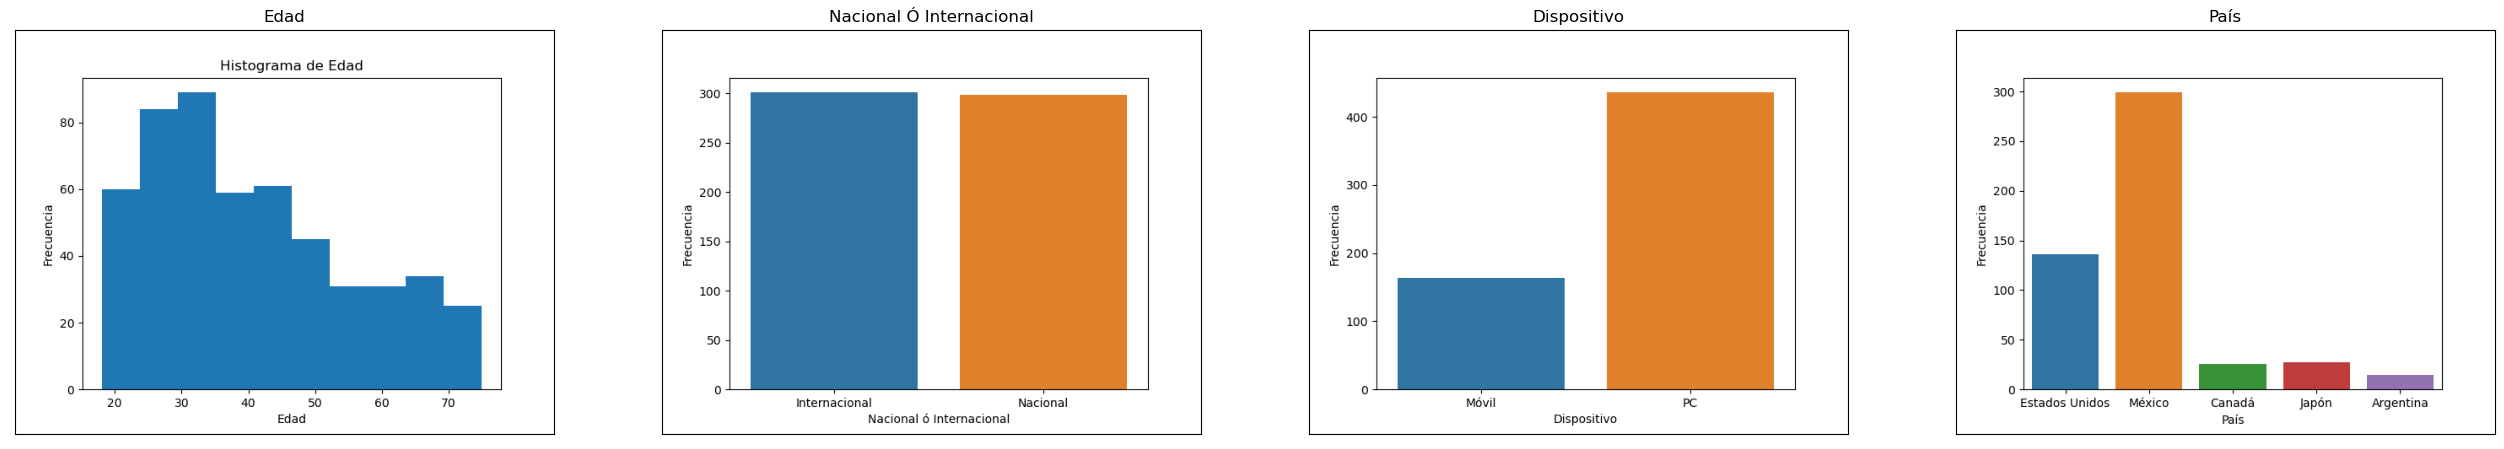

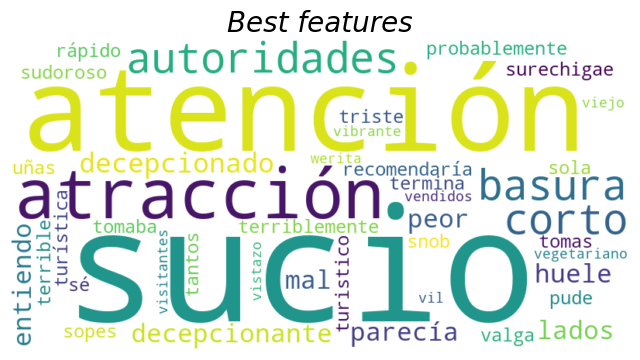

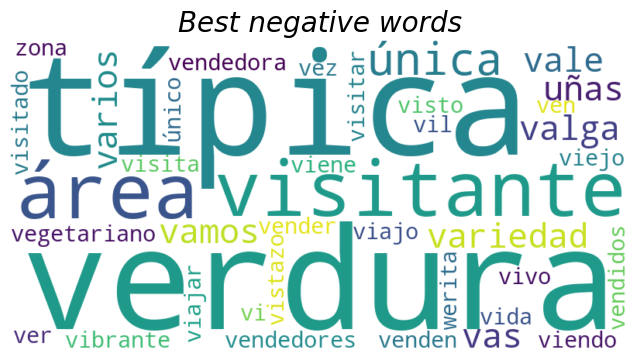

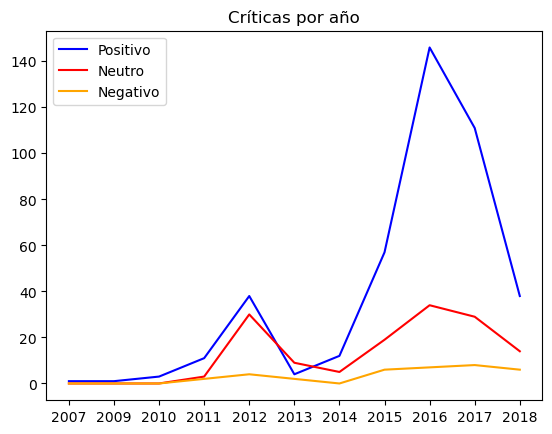

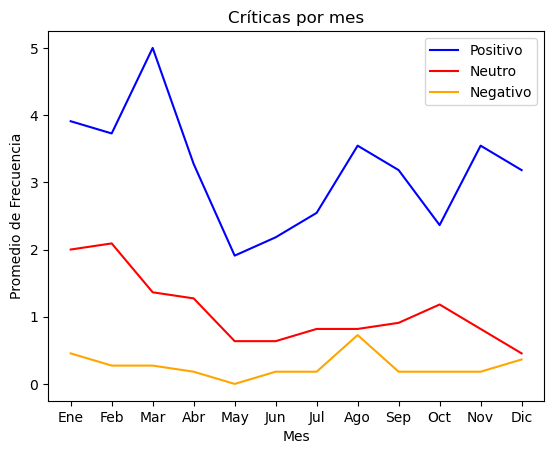

Hombres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2075 
 0.324054 
 mercado 
 
 
 686 
 0.263032 
 comida 
 
 
 1960 
 0.221872 
 lugar 
 
 
 717 
 0.184309 
 comprar 
 
 
 2970 
 0.171391 
 si 
 
 
 279 
 0.154317 
 artesanías 
 
 
 2684 
 0.150156 
 puestos 
 
 
 675 
 0.134509 
 comer 
 
 
 2777 
 0.132810 
 recuerdos 
 
 
 1588 
 0.118777 
 guanajuato 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 1960 
 0.374572 
 lugar 
 
 
 438 
 0.287161 
 buen 
 
 
 675 
 0.202056 
 comer 
 
 
 2684 
 -0.192012 
 puestos 
 
 
 2580 
 0.184021 
 precio 
 
 
 2075 
 -0.154942 
 mercado 
 
 
 2435 
 -0.147907 
 pena 
 
 
 3265 
 -0.142804 
 vale 
 
 
 1183 
 -0.139371 
 edificio 
 
 
 2505 
 -0.126780 
 piso 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2970 
 0.437789 
 si 
 
 
 675 
 0.244108 
 comer 
 
 
 2716 
 0.171450 
 quieres 
 
 
 1154 
 -0.167024 
 dulces 
 
 
 279 
 -0.158547 
 artesanías 
 
 
 2435 
 0.155991 
 pena 
 
 
 2514 
 -0.148837 
 planta 
 
 
 2075 
 -0.147222 
 mercado 
 
 
 3265 
 0.141470 
 vale 
 
 
 1960 
 -0.141056 
 lugar

Mujeres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2075 
 0.324038 
 mercado 
 
 
 686 
 0.263053 
 comida 
 
 
 1960 
 0.221857 
 lugar 
 
 
 717 
 0.184315 
 comprar 
 
 
 2970 
 0.171400 
 si 
 
 
 279 
 0.154341 
 artesanías 
 
 
 2684 
 0.150176 
 puestos 
 
 
 675 
 0.134501 
 comer 
 
 
 2777 
 0.132815 
 recuerdos 
 
 
 1588 
 0.118785 
 guanajuato 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 1960 
 0.373885 
 lugar 
 
 
 438 
 0.305160 
 buen 
 
 
 2580 
 0.205453 
 precio 
 
 
 2684 
 -0.185067 
 puestos 
 
 
 675 
 0.177143 
 comer 
 
 
 1183 
 -0.152431 
 edificio 
 
 
 2075 
 -0.142422 
 mercado 
 
 
 2505 
 -0.142192 
 piso 
 
 
 1807 
 -0.131569 
 interior 
 
 
 2435 
 -0.129592 
 pena 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2970 
 0.418227 
 si 
 
 
 675 
 0.199940 
 comer 
 
 
 2435 
 0.173712 
 pena 
 
 
 1154 
 -0.173357 
 dulces 
 
 
 2075 
 -0.171408 
 mercado 
 
 
 262 
 -0.160660 
 arquitectura 
 
 
 279 
 -0.159387 
 artesanías 
 
 
 3265 
 0.157502 
 vale 
 
 
 2716 
 0.154895 
 quieres 
 
 
 2514 
 -0.154857 
 planta

Turistas Nacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2075 
 0.324041 
 mercado 
 
 
 686 
 0.263049 
 comida 
 
 
 1960 
 0.221873 
 lugar 
 
 
 717 
 0.184309 
 comprar 
 
 
 2970 
 0.171381 
 si 
 
 
 279 
 0.154338 
 artesanías 
 
 
 2684 
 0.150173 
 puestos 
 
 
 675 
 0.134489 
 comer 
 
 
 2777 
 0.132810 
 recuerdos 
 
 
 1588 
 0.118777 
 guanajuato 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 1960 
 0.384259 
 lugar 
 
 
 438 
 0.302218 
 buen 
 
 
 675 
 0.223569 
 comer 
 
 
 2684 
 -0.195942 
 puestos 
 
 
 2580 
 0.192954 
 precio 
 
 
 2435 
 -0.149787 
 pena 
 
 
 3265 
 -0.144215 
 vale 
 
 
 1183 
 -0.140754 
 edificio 
 
 
 2075 
 -0.140427 
 mercado 
 
 
 2505 
 -0.127792 
 piso 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2970 
 0.383498 
 si 
 
 
 675 
 0.224196 
 comer 
 
 
 279 
 -0.220332 
 artesanías 
 
 
 1154 
 -0.214837 
 dulces 
 
 
 2435 
 0.180955 
 pena 
 
 
 2514 
 -0.174381 
 planta 
 
 
 3265 
 0.164882 
 vale 
 
 
 2716 
 0.151585 
 quieres 
 
 
 262 
 -0.143014 
 arquitectura 
 
 
 2075 
 -0.130574 
 mercado

Turistas Internacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2075 
 0.324050 
 mercado 
 
 
 686 
 0.263039 
 comida 
 
 
 1960 
 0.221861 
 lugar 
 
 
 717 
 0.184312 
 comprar 
 
 
 2970 
 0.171404 
 si 
 
 
 279 
 0.154340 
 artesanías 
 
 
 2684 
 0.150166 
 puestos 
 
 
 675 
 0.134485 
 comer 
 
 
 2777 
 0.132806 
 recuerdos 
 
 
 1588 
 0.118790 
 guanajuato 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 1960 
 0.370042 
 lugar 
 
 
 438 
 0.287153 
 buen 
 
 
 675 
 0.186428 
 comer 
 
 
 2684 
 -0.186422 
 puestos 
 
 
 2580 
 0.186111 
 precio 
 
 
 1183 
 -0.146697 
 edificio 
 
 
 2435 
 -0.145915 
 pena 
 
 
 3265 
 -0.141361 
 vale 
 
 
 2505 
 -0.138070 
 piso 
 
 
 1562 
 -0.129977 
 gran 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2970 
 0.437729 
 si 
 
 
 675 
 0.227576 
 comer 
 
 
 279 
 -0.207800 
 artesanías 
 
 
 1154 
 -0.185078 
 dulces 
 
 
 2514 
 -0.169189 
 planta 
 
 
 2435 
 0.161269 
 pena 
 
 
 2716 
 0.152091 
 quieres 
 
 
 1960 
 -0.152005 
 lugar 
 
 
 249 
 0.150482 
 aquí 
 
 
 3265 
 0.142067 
 vale

Personas Jovenes


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2075 
 0.324046 
 mercado 
 
 
 686 
 0.263048 
 comida 
 
 
 1960 
 0.221856 
 lugar 
 
 
 717 
 0.184303 
 comprar 
 
 
 2970 
 0.171410 
 si 
 
 
 279 
 0.154338 
 artesanías 
 
 
 2684 
 0.150177 
 puestos 
 
 
 675 
 0.134497 
 comer 
 
 
 2777 
 0.132810 
 recuerdos 
 
 
 1588 
 0.118784 
 guanajuato 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 1960 
 0.384226 
 lugar 
 
 
 438 
 0.290323 
 buen 
 
 
 675 
 0.218707 
 comer 
 
 
 2684 
 -0.176701 
 puestos 
 
 
 2580 
 0.175192 
 precio 
 
 
 2075 
 -0.153506 
 mercado 
 
 
 2435 
 -0.146153 
 pena 
 
 
 3265 
 -0.141288 
 vale 
 
 
 1183 
 -0.134486 
 edificio 
 
 
 2505 
 -0.133244 
 piso 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2970 
 0.423669 
 si 
 
 
 675 
 0.232537 
 comer 
 
 
 279 
 -0.221048 
 artesanías 
 
 
 1154 
 -0.220771 
 dulces 
 
 
 2716 
 0.162159 
 quieres 
 
 
 262 
 -0.151916 
 arquitectura 
 
 
 2514 
 -0.142977 
 planta 
 
 
 249 
 0.134279 
 aquí 
 
 
 1807 
 -0.130441 
 interior 
 
 
 2435 
 0.127274 
 pena

Personas Mayor


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 2075 
 0.324051 
 mercado 
 
 
 686 
 0.263063 
 comida 
 
 
 1960 
 0.221862 
 lugar 
 
 
 717 
 0.184300 
 comprar 
 
 
 2970 
 0.171390 
 si 
 
 
 279 
 0.154317 
 artesanías 
 
 
 2684 
 0.150184 
 puestos 
 
 
 675 
 0.134510 
 comer 
 
 
 2777 
 0.132829 
 recuerdos 
 
 
 1588 
 0.118788 
 guanajuato 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 1960 
 0.372471 
 lugar 
 
 
 438 
 0.310582 
 buen 
 
 
 675 
 0.219468 
 comer 
 
 
 2580 
 0.201374 
 precio 
 
 
 2684 
 -0.181689 
 puestos 
 
 
 1183 
 -0.145048 
 edificio 
 
 
 2970 
 0.135749 
 si 
 
 
 2435 
 -0.135232 
 pena 
 
 
 2505 
 -0.133723 
 piso 
 
 
 3265 
 -0.132473 
 vale 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2970 
 0.435625 
 si 
 
 
 675 
 0.227580 
 comer 
 
 
 279 
 -0.202274 
 artesanías 
 
 
 1154 
 -0.199108 
 dulces 
 
 
 2435 
 0.165801 
 pena 
 
 
 2716 
 0.164305 
 quieres 
 
 
 717 
 0.151291 
 comprar 
 
 
 3265 
 0.149881 
 vale 
 
 
 2514 
 -0.137100 
 planta 
 
 
 1807 
 -0.133681 
 interior

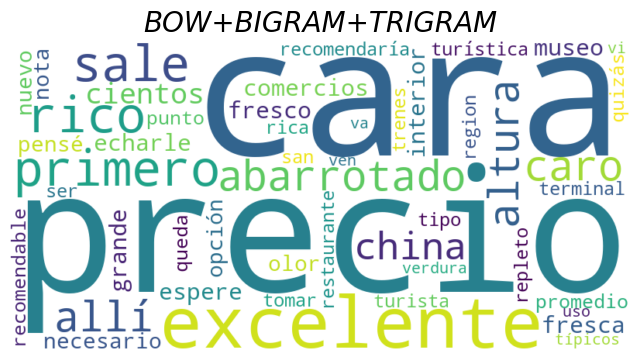

MonumentoPípila
Promedio Puntaje:  4.38 Desviación Estandar: 0.77
Promedio Longitud 47.35 Desviación Estandar 36.15


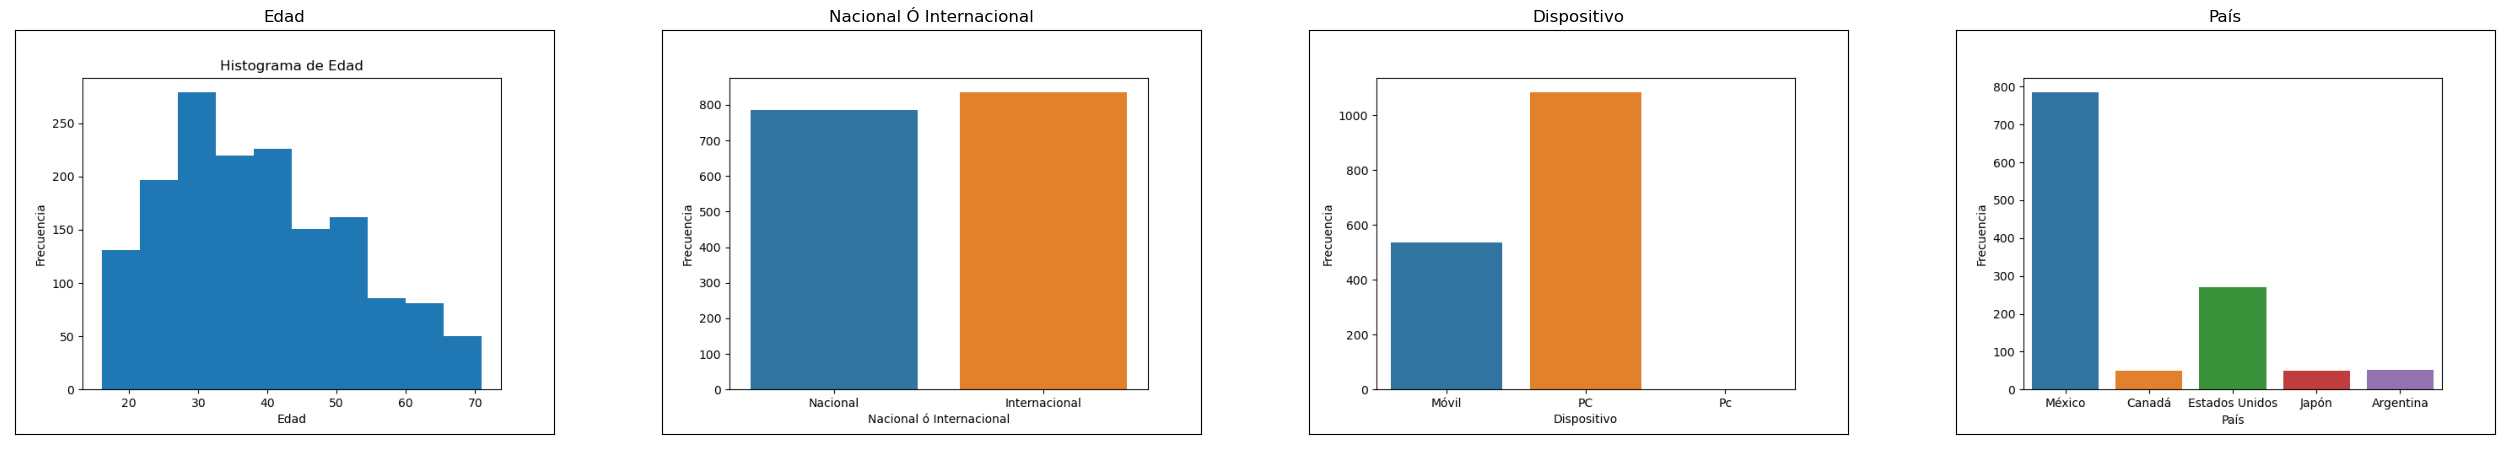

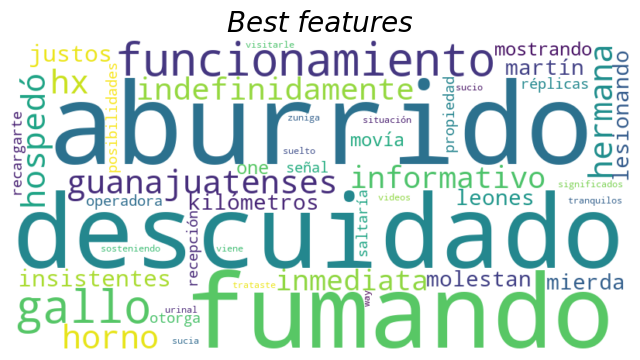

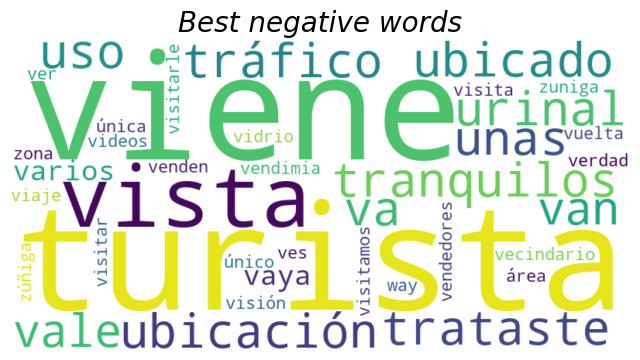

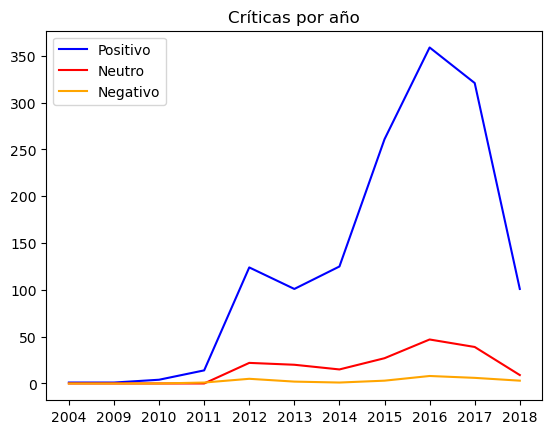

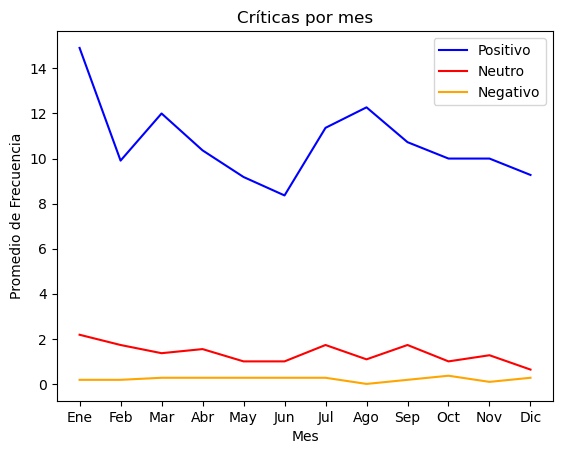

Hombres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1015 
 0.307328 
 ciudad 
 
 
 5295 
 0.293677 
 vista 
 
 
 2465 
 0.253869 
 guanajuato 
 
 
 3334 
 0.227127 
 monumento 
 
 
 3110 
 0.202036 
 lugar 
 
 
 4116 
 0.194571 
 puedes 
 
 
 4737 
 0.173747 
 subir 
 
 
 2355 
 0.161978 
 funicular 
 
 
 4623 
 0.150767 
 si 
 
 
 5202 
 0.138767 
 ver 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 3110 
 -0.416975 
 lugar 
 
 
 4737 
 0.295027 
 subir 
 
 
 3750 
 0.283415 
 pena 
 
 
 5121 
 0.274767 
 vale 
 
 
 2465 
 -0.250849 
 guanajuato 
 
 
 2355 
 0.243056 
 funicular 
 
 
 4913 
 -0.153614 
 toda 
 
 
 3820 
 0.133522 
 pesos 
 
 
 2136 
 -0.129108 
 excelente 
 
 
 444 
 0.123135 
 arriba 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4116 
 0.429479 
 puedes 
 
 
 3334 
 -0.373370 
 monumento 
 
 
 4925 
 0.236895 
 tomar 
 
 
 5121 
 -0.215703 
 vale 
 
 
 3750 
 -0.210965 
 pena 
 
 
 2568 
 -0.182515 
 historia 
 
 
 5202 
 0.175240 
 ver 
 
 
 5295 
 -0.167324 
 vista 
 
 
 4851 
 0.155962 
 teleférico 
 
 
 3110 
 0.155363 
 lugar

Mujeres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1015 
 0.307328 
 ciudad 
 
 
 5295 
 0.293677 
 vista 
 
 
 2465 
 0.253868 
 guanajuato 
 
 
 3334 
 0.227130 
 monumento 
 
 
 3110 
 0.202035 
 lugar 
 
 
 4116 
 0.194571 
 puedes 
 
 
 4737 
 0.173747 
 subir 
 
 
 2355 
 0.161976 
 funicular 
 
 
 4623 
 0.150766 
 si 
 
 
 5202 
 0.138765 
 ver 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 3110 
 -0.408066 
 lugar 
 
 
 4737 
 0.307894 
 subir 
 
 
 3750 
 0.286121 
 pena 
 
 
 5121 
 0.277216 
 vale 
 
 
 2355 
 0.245049 
 funicular 
 
 
 2465 
 -0.243512 
 guanajuato 
 
 
 4913 
 -0.149940 
 toda 
 
 
 3820 
 0.130105 
 pesos 
 
 
 1007 
 0.128302 
 cima 
 
 
 444 
 0.125416 
 arriba 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4116 
 0.455544 
 puedes 
 
 
 3334 
 -0.326052 
 monumento 
 
 
 4925 
 0.295524 
 tomar 
 
 
 5121 
 -0.234231 
 vale 
 
 
 3750 
 -0.228615 
 pena 
 
 
 4851 
 0.181213 
 teleférico 
 
 
 2311 
 0.161917 
 fotos 
 
 
 5202 
 0.159654 
 ver 
 
 
 2568 
 -0.158721 
 historia 
 
 
 5295 
 -0.144932 
 vista

Turistas Nacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1015 
 0.307328 
 ciudad 
 
 
 5295 
 0.293676 
 vista 
 
 
 2465 
 0.253867 
 guanajuato 
 
 
 3334 
 0.227127 
 monumento 
 
 
 3110 
 0.202037 
 lugar 
 
 
 4116 
 0.194567 
 puedes 
 
 
 4737 
 0.173748 
 subir 
 
 
 2355 
 0.161978 
 funicular 
 
 
 4623 
 0.150765 
 si 
 
 
 5202 
 0.138767 
 ver 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 3110 
 -0.411746 
 lugar 
 
 
 4737 
 0.310127 
 subir 
 
 
 3750 
 0.282842 
 pena 
 
 
 5121 
 0.274084 
 vale 
 
 
 2465 
 -0.244497 
 guanajuato 
 
 
 2355 
 0.244017 
 funicular 
 
 
 4913 
 -0.151829 
 toda 
 
 
 3820 
 0.130135 
 pesos 
 
 
 444 
 0.125353 
 arriba 
 
 
 1007 
 0.123981 
 cima 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4116 
 0.393900 
 puedes 
 
 
 3334 
 -0.382576 
 monumento 
 
 
 4925 
 0.266329 
 tomar 
 
 
 5121 
 -0.234525 
 vale 
 
 
 3750 
 -0.230529 
 pena 
 
 
 2568 
 -0.195412 
 historia 
 
 
 2311 
 0.158325 
 fotos 
 
 
 4851 
 0.157680 
 teleférico 
 
 
 5202 
 0.138088 
 ver 
 
 
 4149 
 -0.128754 
 pípila

Turistas Internacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1015 
 0.307328 
 ciudad 
 
 
 5295 
 0.293675 
 vista 
 
 
 2465 
 0.253868 
 guanajuato 
 
 
 3334 
 0.227128 
 monumento 
 
 
 3110 
 0.202037 
 lugar 
 
 
 4116 
 0.194571 
 puedes 
 
 
 4737 
 0.173748 
 subir 
 
 
 2355 
 0.161978 
 funicular 
 
 
 4623 
 0.150765 
 si 
 
 
 5202 
 0.138767 
 ver 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 3110 
 -0.420031 
 lugar 
 
 
 4737 
 0.318055 
 subir 
 
 
 3750 
 0.284118 
 pena 
 
 
 5121 
 0.275834 
 vale 
 
 
 2465 
 -0.245556 
 guanajuato 
 
 
 2355 
 0.231113 
 funicular 
 
 
 4913 
 -0.156879 
 toda 
 
 
 3820 
 0.128057 
 pesos 
 
 
 1007 
 0.124465 
 cima 
 
 
 444 
 0.121232 
 arriba 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4116 
 0.452647 
 puedes 
 
 
 3334 
 -0.326207 
 monumento 
 
 
 4925 
 0.240843 
 tomar 
 
 
 5121 
 -0.235326 
 vale 
 
 
 3750 
 -0.229175 
 pena 
 
 
 5202 
 0.180458 
 ver 
 
 
 5295 
 -0.160319 
 vista 
 
 
 3279 
 -0.157344 
 mirador 
 
 
 4851 
 0.155780 
 teleférico 
 
 
 2568 
 -0.154183 
 historia

Personas Jovenes


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1015 
 0.307326 
 ciudad 
 
 
 5295 
 0.293672 
 vista 
 
 
 2465 
 0.253868 
 guanajuato 
 
 
 3334 
 0.227128 
 monumento 
 
 
 3110 
 0.202040 
 lugar 
 
 
 4116 
 0.194569 
 puedes 
 
 
 4737 
 0.173747 
 subir 
 
 
 2355 
 0.161977 
 funicular 
 
 
 4623 
 0.150761 
 si 
 
 
 5202 
 0.138769 
 ver 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 3110 
 -0.403927 
 lugar 
 
 
 4737 
 0.300863 
 subir 
 
 
 3750 
 0.287693 
 pena 
 
 
 5121 
 0.278829 
 vale 
 
 
 2465 
 -0.250053 
 guanajuato 
 
 
 2355 
 0.236747 
 funicular 
 
 
 4913 
 -0.149382 
 toda 
 
 
 3820 
 0.130771 
 pesos 
 
 
 1007 
 0.126583 
 cima 
 
 
 444 
 0.125810 
 arriba 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4116 
 0.440513 
 puedes 
 
 
 3334 
 -0.365268 
 monumento 
 
 
 4925 
 0.250331 
 tomar 
 
 
 5121 
 -0.229042 
 vale 
 
 
 3750 
 -0.222894 
 pena 
 
 
 5202 
 0.177974 
 ver 
 
 
 5295 
 -0.167380 
 vista 
 
 
 4851 
 0.164697 
 teleférico 
 
 
 2568 
 -0.161792 
 historia 
 
 
 1015 
 -0.135153 
 ciudad

Personas Mayor


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1015 
 0.307327 
 ciudad 
 
 
 5295 
 0.293675 
 vista 
 
 
 2465 
 0.253869 
 guanajuato 
 
 
 3334 
 0.227129 
 monumento 
 
 
 3110 
 0.202041 
 lugar 
 
 
 4116 
 0.194569 
 puedes 
 
 
 4737 
 0.173748 
 subir 
 
 
 2355 
 0.161980 
 funicular 
 
 
 4623 
 0.150767 
 si 
 
 
 5202 
 0.138767 
 ver 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 3110 
 -0.418795 
 lugar 
 
 
 4737 
 0.297217 
 subir 
 
 
 3750 
 0.284998 
 pena 
 
 
 5121 
 0.276550 
 vale 
 
 
 2355 
 0.252646 
 funicular 
 
 
 2465 
 -0.243116 
 guanajuato 
 
 
 4913 
 -0.158952 
 toda 
 
 
 3820 
 0.128456 
 pesos 
 
 
 1007 
 0.125975 
 cima 
 
 
 444 
 0.121386 
 arriba 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4116 
 0.440557 
 puedes 
 
 
 3334 
 -0.379442 
 monumento 
 
 
 5121 
 -0.223258 
 vale 
 
 
 3750 
 -0.219901 
 pena 
 
 
 4925 
 0.201253 
 tomar 
 
 
 4851 
 0.161595 
 teleférico 
 
 
 4843 
 0.155039 
 teatro 
 
 
 3279 
 -0.152709 
 mirador 
 
 
 5295 
 -0.150983 
 vista 
 
 
 2935 
 0.149863 
 juárez

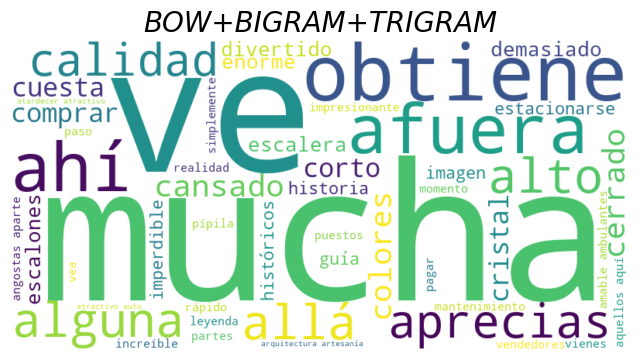

MuseodelasMomias
Promedio Puntaje:  3.68 Desviación Estandar: 1.14
Promedio Longitud 58.07 Desviación Estandar 46.28


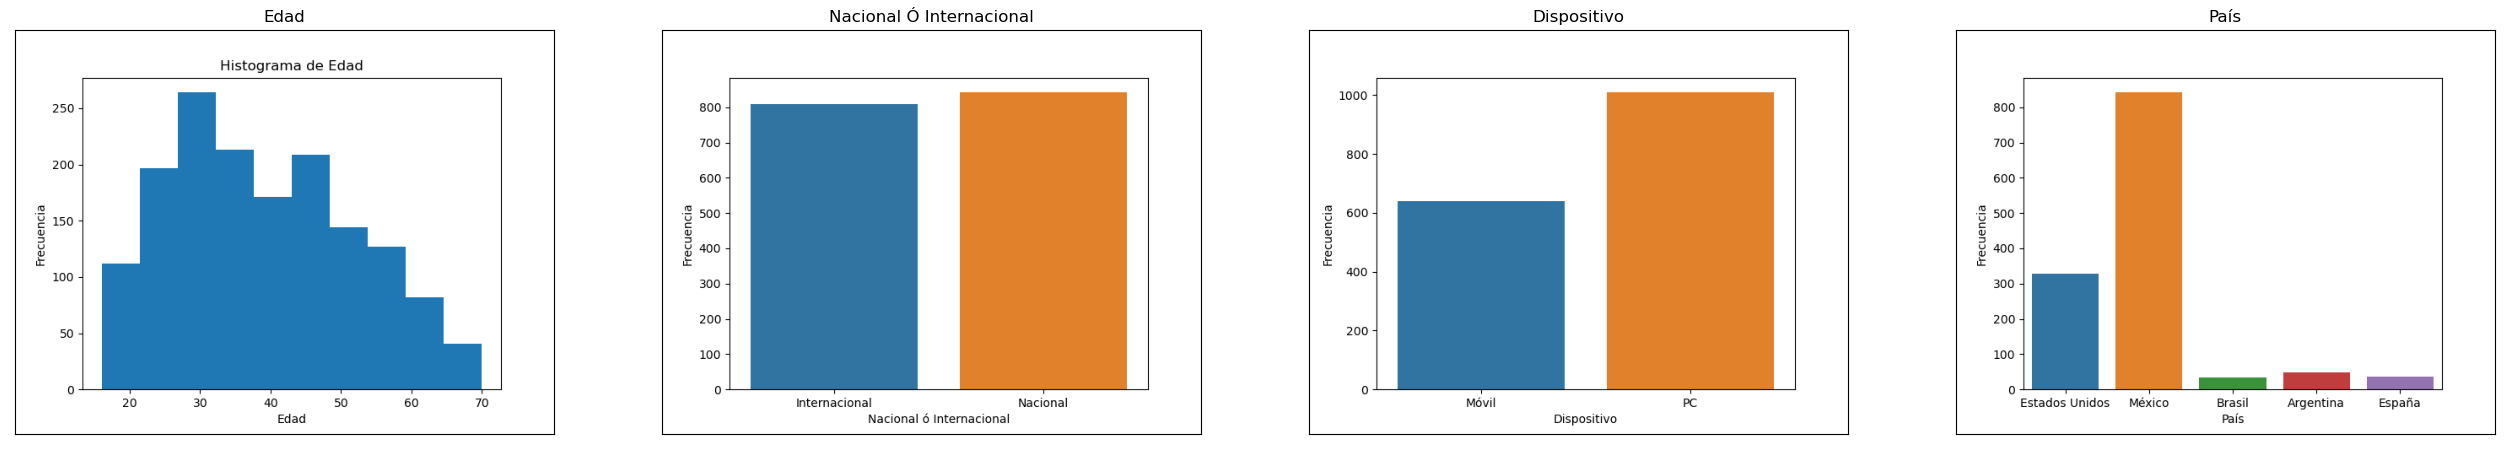

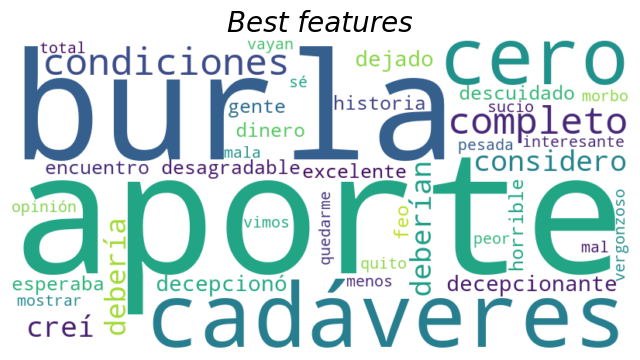

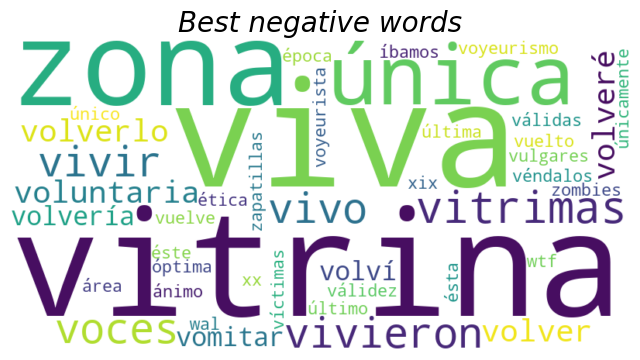

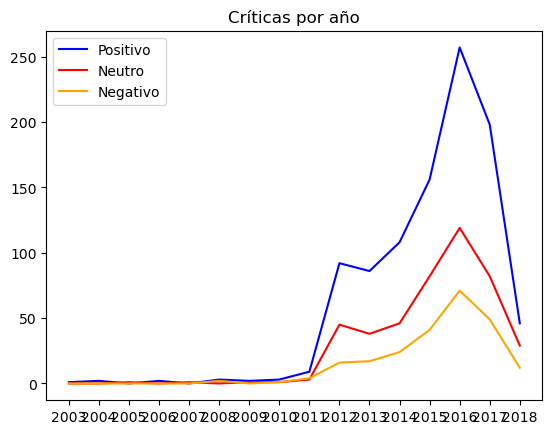

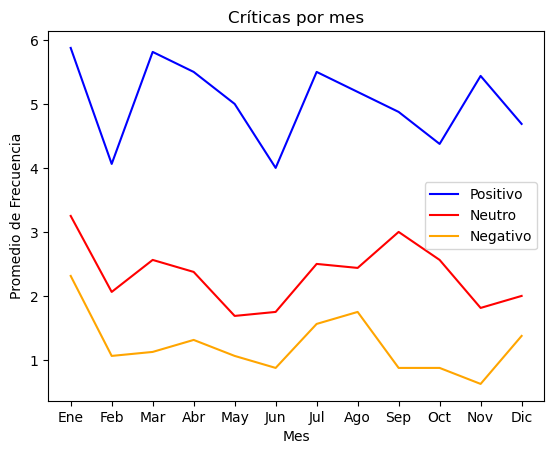

Hombres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 4642 
 0.308540 
 museo 
 
 
 4513 
 0.301008 
 momias 
 
 
 3379 
 0.215883 
 guanajuato 
 
 
 4214 
 0.205203 
 lugar 
 
 
 6335 
 0.201911 
 si 
 
 
 7074 
 0.182419 
 ver 
 
 
 3902 
 0.161813 
 interesante 
 
 
 7174 
 0.142135 
 visita 
 
 
 904 
 0.134496 
 bien 
 
 
 1740 
 0.127298 
 cuerpos 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 1740 
 -0.324314 
 cuerpos 
 
 
 7074 
 -0.226748 
 ver 
 
 
 5830 
 0.220629 
 recorrido 
 
 
 6975 
 0.172142 
 vale 
 
 
 5140 
 0.170008 
 pena 
 
 
 4451 
 0.165767 
 minutos 
 
 
 3964 
 0.150310 
 ir 
 
 
 4522 
 -0.146070 
 momificados 
 
 
 4513 
 -0.138460 
 momias 
 
 
 3142 
 0.136677 
 fila 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4214 
 0.676440 
 lugar 
 
 
 4642 
 -0.226013 
 museo 
 
 
 7184 
 0.187499 
 visitar 
 
 
 3511 
 0.152509 
 historia 
 
 
 3379 
 0.148100 
 guanajuato 
 
 
 1740 
 -0.146692 
 cuerpos 
 
 
 5140 
 -0.141577 
 pena 
 
 
 4451 
 -0.139953 
 minutos 
 
 
 6975 
 -0.111816 
 vale 
 
 
 955 
 0.111331 
 buen

Mujeres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 4642 
 0.308540 
 museo 
 
 
 4513 
 0.301004 
 momias 
 
 
 3379 
 0.215883 
 guanajuato 
 
 
 4214 
 0.205204 
 lugar 
 
 
 6335 
 0.201912 
 si 
 
 
 7074 
 0.182416 
 ver 
 
 
 3902 
 0.161816 
 interesante 
 
 
 7174 
 0.142134 
 visita 
 
 
 904 
 0.134497 
 bien 
 
 
 1740 
 0.127303 
 cuerpos 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 1740 
 -0.299407 
 cuerpos 
 
 
 5830 
 0.223724 
 recorrido 
 
 
 7074 
 -0.202036 
 ver 
 
 
 5140 
 0.180372 
 pena 
 
 
 6975 
 0.179246 
 vale 
 
 
 4755 
 -0.169448 
 niños 
 
 
 7174 
 0.163728 
 visita 
 
 
 4451 
 0.163307 
 minutos 
 
 
 4513 
 -0.159156 
 momias 
 
 
 3142 
 0.147958 
 fila 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4214 
 0.671005 
 lugar 
 
 
 4642 
 -0.206658 
 museo 
 
 
 7184 
 0.182337 
 visitar 
 
 
 1740 
 -0.170219 
 cuerpos 
 
 
 4451 
 -0.166199 
 minutos 
 
 
 5140 
 -0.145525 
 pena 
 
 
 3511 
 0.138120 
 historia 
 
 
 3379 
 0.134642 
 guanajuato 
 
 
 6975 
 -0.115633 
 vale 
 
 
 955 
 0.114594 
 buen

Turistas Nacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 4642 
 0.308543 
 museo 
 
 
 4513 
 0.301003 
 momias 
 
 
 3379 
 0.215883 
 guanajuato 
 
 
 4214 
 0.205207 
 lugar 
 
 
 6335 
 0.201912 
 si 
 
 
 7074 
 0.182413 
 ver 
 
 
 3902 
 0.161814 
 interesante 
 
 
 7174 
 0.142132 
 visita 
 
 
 904 
 0.134499 
 bien 
 
 
 1740 
 0.127305 
 cuerpos 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 1740 
 -0.296375 
 cuerpos 
 
 
 7074 
 -0.237795 
 ver 
 
 
 5830 
 0.232948 
 recorrido 
 
 
 6975 
 0.177308 
 vale 
 
 
 5140 
 0.175882 
 pena 
 
 
 7174 
 0.165068 
 visita 
 
 
 4451 
 0.156844 
 minutos 
 
 
 3142 
 0.155652 
 fila 
 
 
 3964 
 0.149468 
 ir 
 
 
 4755 
 -0.147033 
 niños 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4214 
 0.665796 
 lugar 
 
 
 4642 
 -0.203617 
 museo 
 
 
 7184 
 0.188401 
 visitar 
 
 
 3379 
 0.179538 
 guanajuato 
 
 
 1740 
 -0.169480 
 cuerpos 
 
 
 5140 
 -0.160774 
 pena 
 
 
 3511 
 0.134658 
 historia 
 
 
 4451 
 -0.128919 
 minutos 
 
 
 6975 
 -0.128106 
 vale 
 
 
 3964 
 0.111432 
 ir

Turistas Internacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 4642 
 0.308540 
 museo 
 
 
 4513 
 0.301000 
 momias 
 
 
 3379 
 0.215884 
 guanajuato 
 
 
 4214 
 0.205204 
 lugar 
 
 
 6335 
 0.201914 
 si 
 
 
 7074 
 0.182410 
 ver 
 
 
 3902 
 0.161812 
 interesante 
 
 
 7174 
 0.142132 
 visita 
 
 
 904 
 0.134500 
 bien 
 
 
 1740 
 0.127304 
 cuerpos 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 1740 
 -0.302358 
 cuerpos 
 
 
 7074 
 -0.223923 
 ver 
 
 
 5830 
 0.211308 
 recorrido 
 
 
 6975 
 0.189997 
 vale 
 
 
 5140 
 0.186663 
 pena 
 
 
 4755 
 -0.183502 
 niños 
 
 
 3142 
 0.155507 
 fila 
 
 
 4451 
 0.148142 
 minutos 
 
 
 3964 
 0.143490 
 ir 
 
 
 4522 
 -0.135713 
 momificados 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4214 
 0.688381 
 lugar 
 
 
 4642 
 -0.199330 
 museo 
 
 
 7184 
 0.191099 
 visitar 
 
 
 1740 
 -0.161233 
 cuerpos 
 
 
 5140 
 -0.148740 
 pena 
 
 
 3511 
 0.147928 
 historia 
 
 
 3379 
 0.139384 
 guanajuato 
 
 
 4451 
 -0.138323 
 minutos 
 
 
 6975 
 -0.119826 
 vale 
 
 
 955 
 0.106911 
 buen

Personas Jovenes


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 4642 
 0.308541 
 museo 
 
 
 4513 
 0.301003 
 momias 
 
 
 3379 
 0.215884 
 guanajuato 
 
 
 4214 
 0.205205 
 lugar 
 
 
 6335 
 0.201910 
 si 
 
 
 7074 
 0.182411 
 ver 
 
 
 3902 
 0.161815 
 interesante 
 
 
 7174 
 0.142134 
 visita 
 
 
 904 
 0.134499 
 bien 
 
 
 1740 
 0.127305 
 cuerpos 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 1740 
 -0.292111 
 cuerpos 
 
 
 5830 
 0.224367 
 recorrido 
 
 
 7074 
 -0.211361 
 ver 
 
 
 6975 
 0.184720 
 vale 
 
 
 5140 
 0.184398 
 pena 
 
 
 4755 
 -0.172513 
 niños 
 
 
 3964 
 0.172479 
 ir 
 
 
 4451 
 0.168945 
 minutos 
 
 
 3142 
 0.160819 
 fila 
 
 
 4513 
 -0.154902 
 momias 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4214 
 0.675651 
 lugar 
 
 
 4642 
 -0.199120 
 museo 
 
 
 7184 
 0.176988 
 visitar 
 
 
 1740 
 -0.172895 
 cuerpos 
 
 
 5140 
 -0.160347 
 pena 
 
 
 4451 
 -0.153001 
 minutos 
 
 
 3511 
 0.148518 
 historia 
 
 
 6975 
 -0.128464 
 vale 
 
 
 3379 
 0.118091 
 guanajuato 
 
 
 955 
 0.105885 
 buen

Personas Mayor


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 4642 
 0.308542 
 museo 
 
 
 4513 
 0.301004 
 momias 
 
 
 3379 
 0.215884 
 guanajuato 
 
 
 4214 
 0.205204 
 lugar 
 
 
 6335 
 0.201914 
 si 
 
 
 7074 
 0.182413 
 ver 
 
 
 3902 
 0.161816 
 interesante 
 
 
 7174 
 0.142129 
 visita 
 
 
 904 
 0.134500 
 bien 
 
 
 1740 
 0.127303 
 cuerpos 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 1740 
 -0.308877 
 cuerpos 
 
 
 5830 
 0.220492 
 recorrido 
 
 
 7074 
 -0.220249 
 ver 
 
 
 6975 
 0.184659 
 vale 
 
 
 5140 
 0.182787 
 pena 
 
 
 4755 
 -0.172982 
 niños 
 
 
 3142 
 0.155988 
 fila 
 
 
 4451 
 0.151089 
 minutos 
 
 
 4522 
 -0.139932 
 momificados 
 
 
 4513 
 -0.138231 
 momias 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 4214 
 0.702038 
 lugar 
 
 
 4642 
 -0.224350 
 museo 
 
 
 7184 
 0.185657 
 visitar 
 
 
 1740 
 -0.164607 
 cuerpos 
 
 
 4451 
 -0.142128 
 minutos 
 
 
 5140 
 -0.138001 
 pena 
 
 
 3379 
 0.137256 
 guanajuato 
 
 
 3511 
 0.131091 
 historia 
 
 
 955 
 0.115866 
 buen 
 
 
 6975 
 -0.110962 
 vale

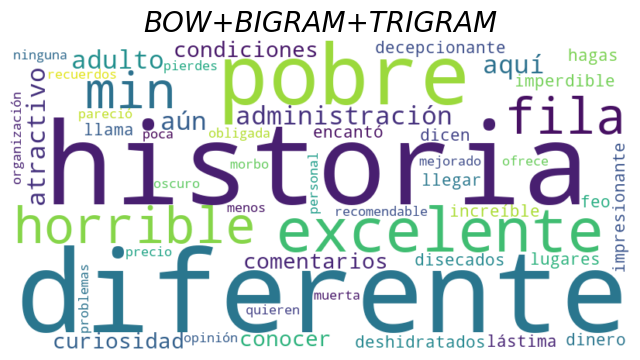

TeatroJuárez
Promedio Puntaje:  4.7 Desviación Estandar: 0.52
Promedio Longitud 41.62 Desviación Estandar 27.18


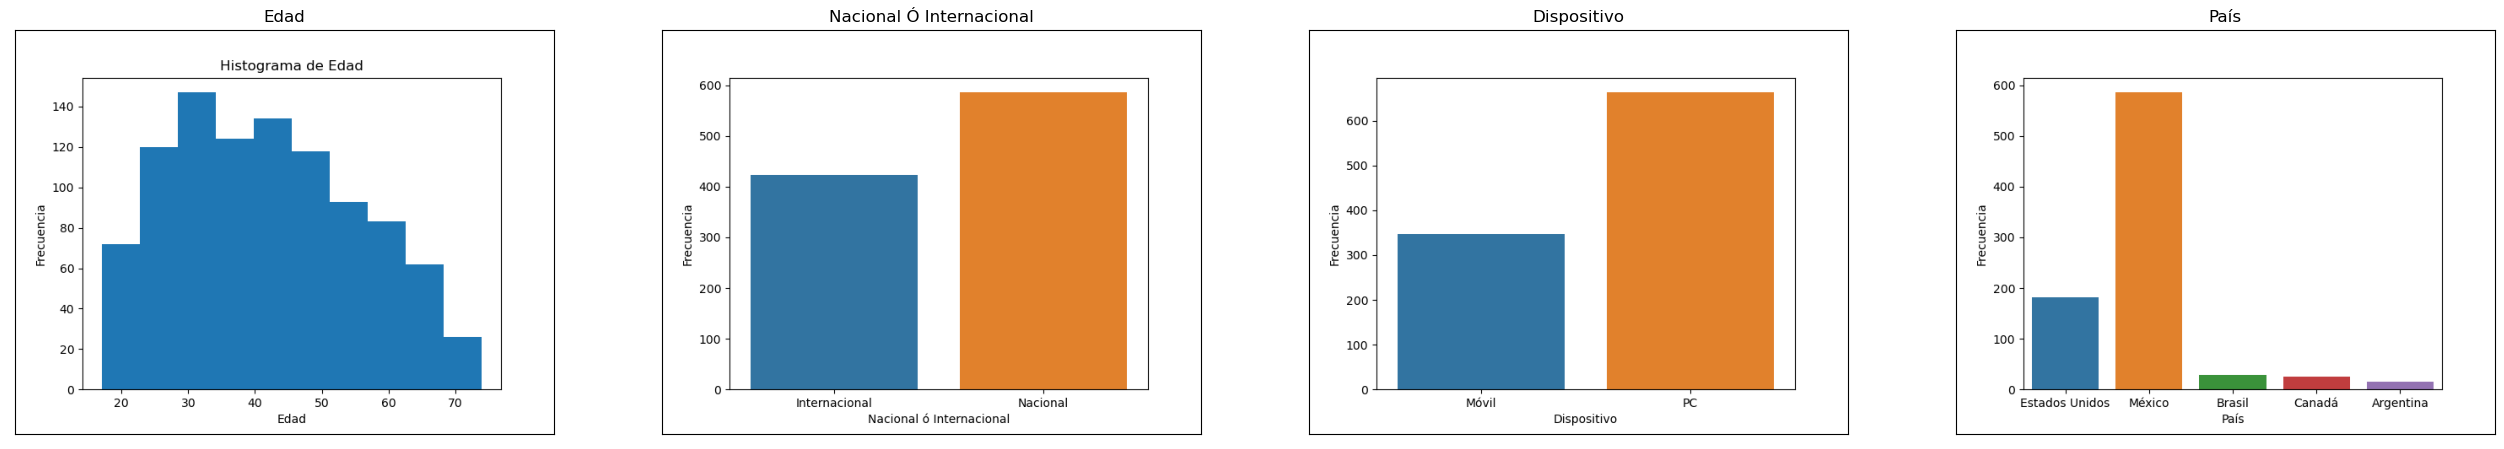

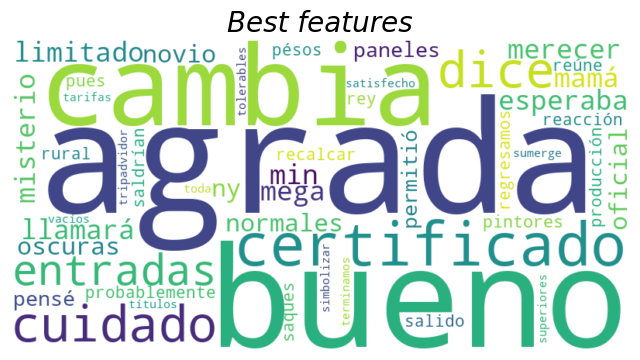

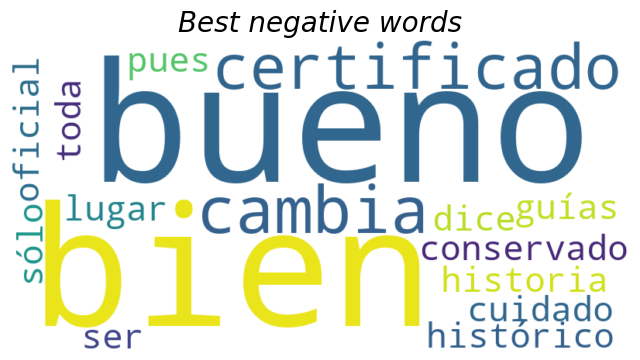

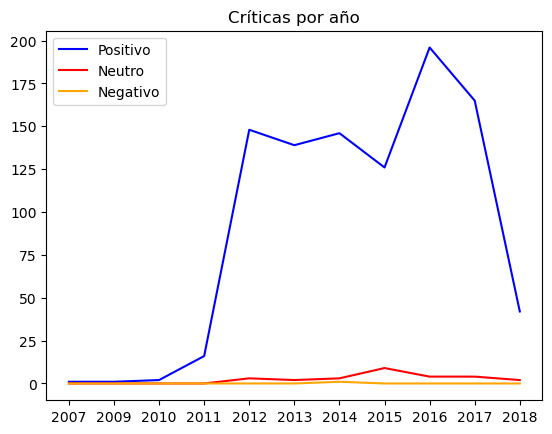

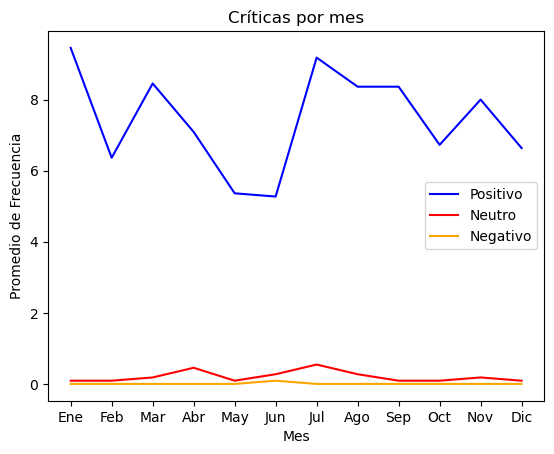

Hombres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 3779 
 0.334365 
 teatro 
 
 
 2368 
 0.255404 
 lugar 
 
 
 1894 
 0.202678 
 guanajuato 
 
 
 1969 
 0.200261 
 hermoso 
 
 
 2960 
 0.165503 
 pena 
 
 
 346 
 0.162086 
 arquitectura 
 
 
 733 
 0.159783 
 ciudad 
 
 
 4000 
 0.157055 
 vale 
 
 
 4050 
 0.154206 
 ver 
 
 
 1983 
 0.151944 
 historia 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2368 
 0.467632 
 lugar 
 
 
 2960 
 -0.300842 
 pena 
 
 
 4000 
 -0.293959 
 vale 
 
 
 1894 
 0.234130 
 guanajuato 
 
 
 1983 
 0.211460 
 historia 
 
 
 4130 
 0.196722 
 visitar 
 
 
 4050 
 -0.189478 
 ver 
 
 
 1456 
 -0.143393 
 entrar 
 
 
 2193 
 -0.138706 
 interior 
 
 
 346 
 0.134408 
 arquitectura 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2960 
 0.318487 
 pena 
 
 
 4000 
 0.306484 
 vale 
 
 
 2368 
 0.286574 
 lugar 
 
 
 733 
 -0.282131 
 ciudad 
 
 
 1983 
 0.225698 
 historia 
 
 
 2704 
 -0.211636 
 noche 
 
 
 686 
 -0.183328 
 centro 
 
 
 4050 
 -0.144585 
 ver 
 
 
 521 
 0.140162 
 bien 
 
 
 4130 
 0.139486 
 visitar

Mujeres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 3779 
 0.334363 
 teatro 
 
 
 2368 
 0.255416 
 lugar 
 
 
 1894 
 0.202675 
 guanajuato 
 
 
 1969 
 0.200276 
 hermoso 
 
 
 2960 
 0.165499 
 pena 
 
 
 346 
 0.162083 
 arquitectura 
 
 
 733 
 0.159779 
 ciudad 
 
 
 4000 
 0.157052 
 vale 
 
 
 4050 
 0.154211 
 ver 
 
 
 1983 
 0.151939 
 historia 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2368 
 0.466270 
 lugar 
 
 
 2960 
 -0.300170 
 pena 
 
 
 4000 
 -0.294224 
 vale 
 
 
 1894 
 0.233847 
 guanajuato 
 
 
 1983 
 0.210704 
 historia 
 
 
 4130 
 0.199210 
 visitar 
 
 
 4050 
 -0.190742 
 ver 
 
 
 2193 
 -0.140545 
 interior 
 
 
 1456 
 -0.136756 
 entrar 
 
 
 346 
 0.135559 
 arquitectura 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2960 
 0.325234 
 pena 
 
 
 4000 
 0.313117 
 vale 
 
 
 2368 
 0.290518 
 lugar 
 
 
 733 
 -0.273725 
 ciudad 
 
 
 1983 
 0.224209 
 historia 
 
 
 2704 
 -0.194766 
 noche 
 
 
 4050 
 -0.173802 
 ver 
 
 
 686 
 -0.161568 
 centro 
 
 
 521 
 0.148958 
 bien 
 
 
 1310 
 -0.126941 
 día

Turistas Nacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 3779 
 0.334360 
 teatro 
 
 
 2368 
 0.255421 
 lugar 
 
 
 1894 
 0.202676 
 guanajuato 
 
 
 1969 
 0.200246 
 hermoso 
 
 
 2960 
 0.165503 
 pena 
 
 
 346 
 0.162084 
 arquitectura 
 
 
 733 
 0.159770 
 ciudad 
 
 
 4000 
 0.157056 
 vale 
 
 
 4050 
 0.154217 
 ver 
 
 
 1983 
 0.151931 
 historia 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2368 
 0.465590 
 lugar 
 
 
 2960 
 -0.302780 
 pena 
 
 
 4000 
 -0.295897 
 vale 
 
 
 1894 
 0.231761 
 guanajuato 
 
 
 1983 
 0.208586 
 historia 
 
 
 4130 
 0.196646 
 visitar 
 
 
 4050 
 -0.186953 
 ver 
 
 
 346 
 0.146952 
 arquitectura 
 
 
 2193 
 -0.139021 
 interior 
 
 
 1456 
 -0.136524 
 entrar 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2960 
 0.316787 
 pena 
 
 
 4000 
 0.301684 
 vale 
 
 
 2368 
 0.294739 
 lugar 
 
 
 733 
 -0.281908 
 ciudad 
 
 
 1983 
 0.226333 
 historia 
 
 
 2704 
 -0.201717 
 noche 
 
 
 686 
 -0.178751 
 centro 
 
 
 4050 
 -0.148897 
 ver 
 
 
 521 
 0.138542 
 bien 
 
 
 4130 
 0.138294 
 visitar

Turistas Internacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 3779 
 0.334372 
 teatro 
 
 
 2368 
 0.255424 
 lugar 
 
 
 1894 
 0.202669 
 guanajuato 
 
 
 1969 
 0.200276 
 hermoso 
 
 
 2960 
 0.165504 
 pena 
 
 
 346 
 0.162078 
 arquitectura 
 
 
 733 
 0.159780 
 ciudad 
 
 
 4000 
 0.157057 
 vale 
 
 
 4050 
 0.154215 
 ver 
 
 
 1983 
 0.151940 
 historia 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2368 
 0.480576 
 lugar 
 
 
 2960 
 -0.304559 
 pena 
 
 
 4000 
 -0.296385 
 vale 
 
 
 1983 
 0.213430 
 historia 
 
 
 1894 
 0.212133 
 guanajuato 
 
 
 4130 
 0.182552 
 visitar 
 
 
 4050 
 -0.178914 
 ver 
 
 
 2193 
 -0.143069 
 interior 
 
 
 346 
 0.135110 
 arquitectura 
 
 
 1456 
 -0.133327 
 entrar 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2960 
 0.329460 
 pena 
 
 
 4000 
 0.314150 
 vale 
 
 
 2368 
 0.289226 
 lugar 
 
 
 733 
 -0.264383 
 ciudad 
 
 
 1983 
 0.229723 
 historia 
 
 
 2704 
 -0.191814 
 noche 
 
 
 4050 
 -0.163866 
 ver 
 
 
 686 
 -0.157574 
 centro 
 
 
 521 
 0.145482 
 bien 
 
 
 1310 
 -0.128603 
 día

Personas Jovenes


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 3779 
 0.334371 
 teatro 
 
 
 2368 
 0.255422 
 lugar 
 
 
 1894 
 0.202665 
 guanajuato 
 
 
 1969 
 0.200267 
 hermoso 
 
 
 2960 
 0.165502 
 pena 
 
 
 346 
 0.162073 
 arquitectura 
 
 
 733 
 0.159782 
 ciudad 
 
 
 4000 
 0.157056 
 vale 
 
 
 4050 
 0.154202 
 ver 
 
 
 1983 
 0.151939 
 historia 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2368 
 0.465479 
 lugar 
 
 
 2960 
 -0.304802 
 pena 
 
 
 4000 
 -0.297547 
 vale 
 
 
 1894 
 0.231669 
 guanajuato 
 
 
 1983 
 0.208540 
 historia 
 
 
 4050 
 -0.197192 
 ver 
 
 
 4130 
 0.193538 
 visitar 
 
 
 2193 
 -0.143854 
 interior 
 
 
 1456 
 -0.139560 
 entrar 
 
 
 346 
 0.137259 
 arquitectura 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2960 
 0.321038 
 pena 
 
 
 4000 
 0.306654 
 vale 
 
 
 2368 
 0.299765 
 lugar 
 
 
 733 
 -0.273682 
 ciudad 
 
 
 1983 
 0.229825 
 historia 
 
 
 2704 
 -0.216598 
 noche 
 
 
 686 
 -0.174871 
 centro 
 
 
 4050 
 -0.150093 
 ver 
 
 
 1310 
 -0.136043 
 día 
 
 
 4130 
 0.135226 
 visitar

Personas Mayor


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 3779 
 0.334361 
 teatro 
 
 
 2368 
 0.255416 
 lugar 
 
 
 1894 
 0.202675 
 guanajuato 
 
 
 1969 
 0.200263 
 hermoso 
 
 
 2960 
 0.165504 
 pena 
 
 
 346 
 0.162089 
 arquitectura 
 
 
 733 
 0.159775 
 ciudad 
 
 
 4000 
 0.157057 
 vale 
 
 
 4050 
 0.154206 
 ver 
 
 
 1983 
 0.151932 
 historia 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2368 
 0.464130 
 lugar 
 
 
 2960 
 -0.299572 
 pena 
 
 
 4000 
 -0.293005 
 vale 
 
 
 1894 
 0.229880 
 guanajuato 
 
 
 1983 
 0.206335 
 historia 
 
 
 4130 
 0.199626 
 visitar 
 
 
 4050 
 -0.189957 
 ver 
 
 
 1456 
 -0.140030 
 entrar 
 
 
 346 
 0.139248 
 arquitectura 
 
 
 2193 
 -0.136433 
 interior 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 733 
 -0.307184 
 ciudad 
 
 
 2960 
 0.304554 
 pena 
 
 
 2368 
 0.295743 
 lugar 
 
 
 4000 
 0.288136 
 vale 
 
 
 1983 
 0.229872 
 historia 
 
 
 2704 
 -0.217703 
 noche 
 
 
 686 
 -0.163814 
 centro 
 
 
 4050 
 -0.161476 
 ver 
 
 
 1310 
 -0.146804 
 día 
 
 
 521 
 0.139891 
 bien

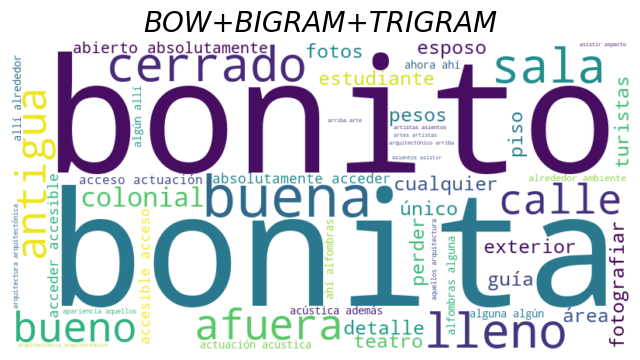

UniversidaddeGuanajuato
Promedio Puntaje:  4.6 Desviación Estandar: 0.61
Promedio Longitud 35.49 Desviación Estandar 20.17


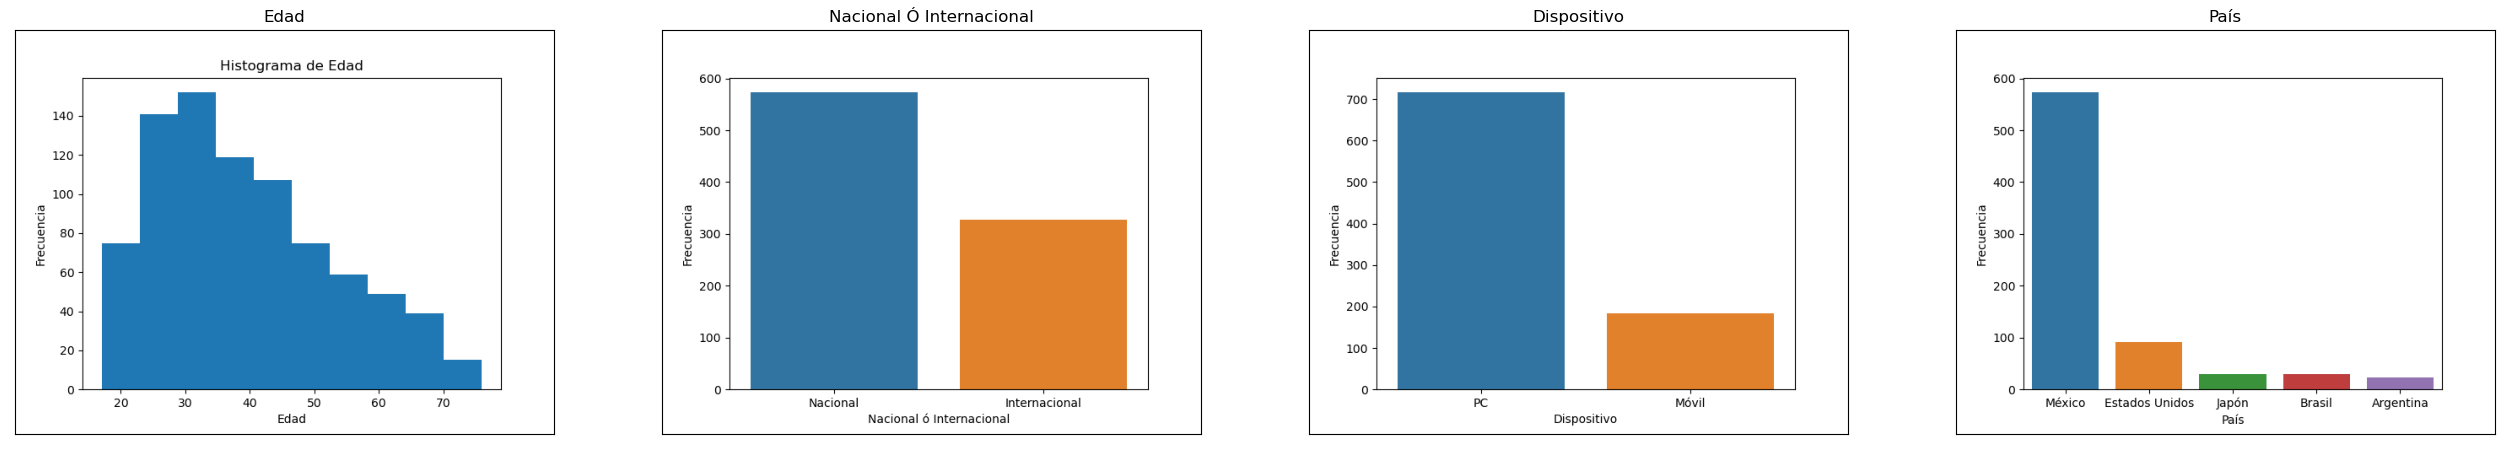

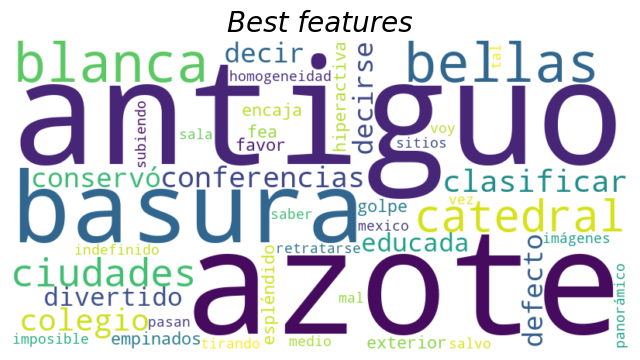

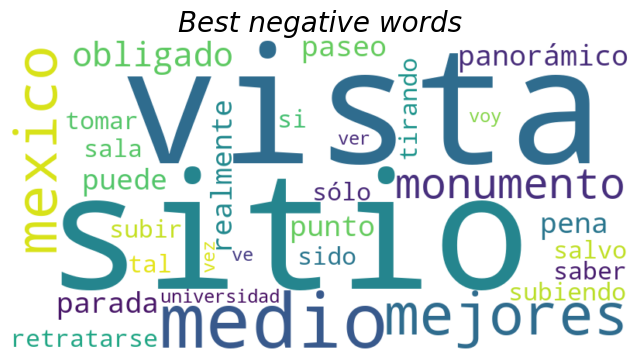

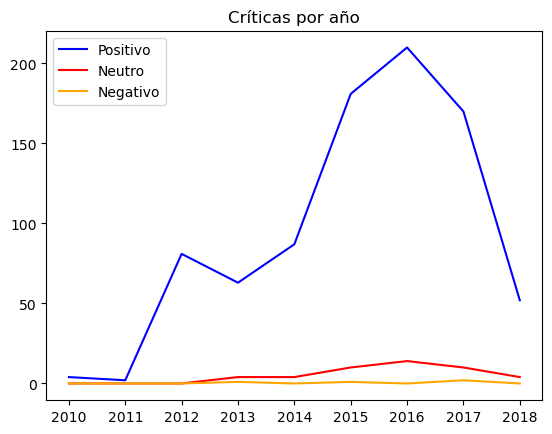

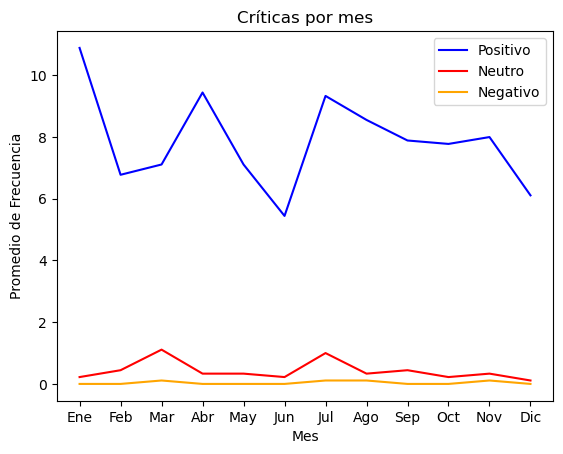

Hombres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1625 
 0.281717 
 guanajuato 
 
 
 3387 
 0.261956 
 universidad 
 
 
 1112 
 0.246463 
 edificio 
 
 
 608 
 0.236117 
 ciudad 
 
 
 2033 
 0.231940 
 lugar 
 
 
 284 
 0.198390 
 arquitectura 
 
 
 3533 
 0.179012 
 vista 
 
 
 1265 
 0.172939 
 escaleras 
 
 
 3057 
 0.155318 
 si 
 
 
 3141 
 0.154670 
 subir 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2033 
 -0.470596 
 lugar 
 
 
 2499 
 0.399661 
 pena 
 
 
 3416 
 0.387502 
 vale 
 
 
 1625 
 -0.270722 
 guanajuato 
 
 
 3519 
 -0.206971 
 visitar 
 
 
 3141 
 0.170325 
 subir 
 
 
 3533 
 0.144357 
 vista 
 
 
 284 
 -0.106514 
 arquitectura 
 
 
 3057 
 -0.104431 
 si 
 
 
 1688 
 0.102446 
 hermosa 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2033 
 0.416606 
 lugar 
 
 
 3416 
 0.295627 
 vale 
 
 
 2499 
 0.294459 
 pena 
 
 
 1532 
 0.231228 
 fotos 
 
 
 608 
 -0.228418 
 ciudad 
 
 
 3387 
 -0.222722 
 universidad 
 
 
 1625 
 -0.216881 
 guanajuato 
 
 
 1112 
 -0.197984 
 edificio 
 
 
 3280 
 0.169294 
 tomar 
 
 
 567 
 -0.139931 
 centro

Mujeres


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1625 
 0.281704 
 guanajuato 
 
 
 3387 
 0.261945 
 universidad 
 
 
 1112 
 0.246465 
 edificio 
 
 
 608 
 0.236111 
 ciudad 
 
 
 2033 
 0.231935 
 lugar 
 
 
 284 
 0.198401 
 arquitectura 
 
 
 3533 
 0.179001 
 vista 
 
 
 1265 
 0.172948 
 escaleras 
 
 
 3057 
 0.155341 
 si 
 
 
 3141 
 0.154660 
 subir 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2033 
 -0.490308 
 lugar 
 
 
 2499 
 0.381961 
 pena 
 
 
 3416 
 0.369526 
 vale 
 
 
 1625 
 -0.264609 
 guanajuato 
 
 
 3519 
 -0.212025 
 visitar 
 
 
 3141 
 0.158583 
 subir 
 
 
 3533 
 0.153545 
 vista 
 
 
 1112 
 0.134435 
 edificio 
 
 
 1688 
 0.111313 
 hermosa 
 
 
 284 
 -0.095230 
 arquitectura 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2033 
 0.373357 
 lugar 
 
 
 3416 
 0.312030 
 vale 
 
 
 2499 
 0.310600 
 pena 
 
 
 1532 
 0.239212 
 fotos 
 
 
 608 
 -0.230344 
 ciudad 
 
 
 1625 
 -0.221598 
 guanajuato 
 
 
 3387 
 -0.211225 
 universidad 
 
 
 3280 
 0.188902 
 tomar 
 
 
 1112 
 -0.158407 
 edificio 
 
 
 1264 
 -0.140031 
 escalera

Turistas Nacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1625 
 0.281722 
 guanajuato 
 
 
 3387 
 0.261953 
 universidad 
 
 
 1112 
 0.246452 
 edificio 
 
 
 608 
 0.236115 
 ciudad 
 
 
 2033 
 0.231929 
 lugar 
 
 
 284 
 0.198407 
 arquitectura 
 
 
 3533 
 0.178999 
 vista 
 
 
 1265 
 0.172939 
 escaleras 
 
 
 3057 
 0.155309 
 si 
 
 
 3141 
 0.154679 
 subir 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2033 
 -0.476316 
 lugar 
 
 
 2499 
 0.400571 
 pena 
 
 
 3416 
 0.389077 
 vale 
 
 
 1625 
 -0.257866 
 guanajuato 
 
 
 3519 
 -0.212283 
 visitar 
 
 
 3141 
 0.172509 
 subir 
 
 
 3533 
 0.143779 
 vista 
 
 
 1688 
 0.116475 
 hermosa 
 
 
 3057 
 -0.109927 
 si 
 
 
 1526 
 -0.095565 
 foto 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2033 
 0.400973 
 lugar 
 
 
 3416 
 0.291767 
 vale 
 
 
 2499 
 0.289278 
 pena 
 
 
 1532 
 0.247392 
 fotos 
 
 
 1625 
 -0.232304 
 guanajuato 
 
 
 608 
 -0.213214 
 ciudad 
 
 
 3387 
 -0.213122 
 universidad 
 
 
 3280 
 0.203136 
 tomar 
 
 
 1112 
 -0.191853 
 edificio 
 
 
 3284 
 0.119952 
 tomarse

Turistas Internacionales


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1625 
 0.281713 
 guanajuato 
 
 
 3387 
 0.261968 
 universidad 
 
 
 1112 
 0.246459 
 edificio 
 
 
 608 
 0.236106 
 ciudad 
 
 
 2033 
 0.231936 
 lugar 
 
 
 284 
 0.198390 
 arquitectura 
 
 
 3533 
 0.179010 
 vista 
 
 
 1265 
 0.172940 
 escaleras 
 
 
 3057 
 0.155335 
 si 
 
 
 3141 
 0.154665 
 subir 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2033 
 -0.465499 
 lugar 
 
 
 2499 
 0.390757 
 pena 
 
 
 3416 
 0.379014 
 vale 
 
 
 1625 
 -0.272680 
 guanajuato 
 
 
 3519 
 -0.233363 
 visitar 
 
 
 3141 
 0.176932 
 subir 
 
 
 3533 
 0.150695 
 vista 
 
 
 3057 
 -0.117670 
 si 
 
 
 1112 
 0.101237 
 edificio 
 
 
 1600 
 0.094292 
 gran 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2033 
 0.409509 
 lugar 
 
 
 3416 
 0.302467 
 vale 
 
 
 2499 
 0.299870 
 pena 
 
 
 1532 
 0.224874 
 fotos 
 
 
 608 
 -0.224418 
 ciudad 
 
 
 1625 
 -0.212429 
 guanajuato 
 
 
 3387 
 -0.201609 
 universidad 
 
 
 1112 
 -0.196047 
 edificio 
 
 
 3280 
 0.177090 
 tomar 
 
 
 1264 
 -0.126821 
 escalera

Personas Jovenes


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1625 
 0.281710 
 guanajuato 
 
 
 3387 
 0.261963 
 universidad 
 
 
 1112 
 0.246457 
 edificio 
 
 
 608 
 0.236112 
 ciudad 
 
 
 2033 
 0.231939 
 lugar 
 
 
 284 
 0.198393 
 arquitectura 
 
 
 3533 
 0.179004 
 vista 
 
 
 1265 
 0.172936 
 escaleras 
 
 
 3057 
 0.155330 
 si 
 
 
 3141 
 0.154666 
 subir 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2033 
 -0.454954 
 lugar 
 
 
 2499 
 0.401506 
 pena 
 
 
 3416 
 0.390551 
 vale 
 
 
 1625 
 -0.276554 
 guanajuato 
 
 
 3519 
 -0.225360 
 visitar 
 
 
 3141 
 0.163805 
 subir 
 
 
 3533 
 0.126039 
 vista 
 
 
 3057 
 -0.101491 
 si 
 
 
 1526 
 -0.101214 
 foto 
 
 
 1600 
 0.099948 
 gran 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2033 
 0.415204 
 lugar 
 
 
 3416 
 0.289815 
 vale 
 
 
 2499 
 0.289164 
 pena 
 
 
 1625 
 -0.211888 
 guanajuato 
 
 
 3387 
 -0.211692 
 universidad 
 
 
 1532 
 0.206760 
 fotos 
 
 
 608 
 -0.202789 
 ciudad 
 
 
 1112 
 -0.190851 
 edificio 
 
 
 3280 
 0.170193 
 tomar 
 
 
 1264 
 -0.132114 
 escalera

Personas Mayor


topic_1 
 
 
   
 topic_1 
 terms 
 
 
 
 
 1625 
 0.281717 
 guanajuato 
 
 
 3387 
 0.261966 
 universidad 
 
 
 1112 
 0.246454 
 edificio 
 
 
 608 
 0.236120 
 ciudad 
 
 
 2033 
 0.231941 
 lugar 
 
 
 284 
 0.198384 
 arquitectura 
 
 
 3533 
 0.179004 
 vista 
 
 
 1265 
 0.172929 
 escaleras 
 
 
 3057 
 0.155314 
 si 
 
 
 3141 
 0.154697 
 subir 
 
 
 

 
 topic_2 
 
 
   
 topic_2 
 terms 
 
 
 
 
 2033 
 -0.483042 
 lugar 
 
 
 2499 
 0.389882 
 pena 
 
 
 3416 
 0.377044 
 vale 
 
 
 1625 
 -0.261464 
 guanajuato 
 
 
 3519 
 -0.225783 
 visitar 
 
 
 3533 
 0.150208 
 vista 
 
 
 3141 
 0.142331 
 subir 
 
 
 1112 
 0.117458 
 edificio 
 
 
 1600 
 0.101626 
 gran 
 
 
 3057 
 -0.093313 
 si 
 
 
 

 
 topic_3 
 
 
   
 topic_3 
 terms 
 
 
 
 
 2033 
 0.394769 
 lugar 
 
 
 3416 
 0.309381 
 vale 
 
 
 2499 
 0.307423 
 pena 
 
 
 1532 
 0.220492 
 fotos 
 
 
 1625 
 -0.213571 
 guanajuato 
 
 
 608 
 -0.209115 
 ciudad 
 
 
 3387 
 -0.205247 
 universidad 
 
 
 1112 
 -0.204192 
 edificio 
 
 
 3280 
 0.175945 
 tomar 
 
 
 2744 
 -0.127795 
 puede

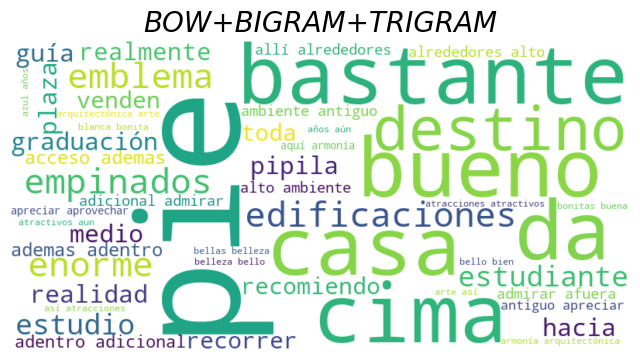

In [225]:
average_and_std = []
average_and_std_woman = []
average_and_std_young = []

for idx, df in enumerate(places):
    name = name_places[idx].split('.')[0]
    print(name)
    score_mean = round(df['Escala'].mean(axis=0),2)
    standar_desviation = round(df['Escala'].std(),2)
    print("Promedio Puntaje: ", score_mean ,"Desviación Estandar:", standar_desviation)
    average_and_std.append((score_mean,standar_desviation, name))
    score_mean = round(df[df['Género'] == 'Femenino']['Escala'].mean(axis=0),2)
    standar_desviation = round(df[df['Género'] == 'Femenino']['Escala'].std(),2)
    average_and_std_woman.append((score_mean, standar_desviation, name))
    score_mean = round(df[df['Edad'] < 30]['Escala'].mean(axis=0),2)
    standar_desviation = round(df[df['Edad'] < 30]['Escala'].std(),2)
    average_and_std_young.append((score_mean, standar_desviation, name))
    
    textos = np.array(df['Opinión'])
    labels = np.array(df['Sentimiento'])
    
    vocabulario = get_vocabulary(textos)
    dict_indices = dict()
    dict_indices_reversed = dict()
    cont = 0
    for word in vocabulario:
        dict_indices[word]=cont
        dict_indices_reversed[cont] = word
        cont += 1 

    opinion_lengths = df['Opinión'].str.split(' ').str.len()
    lenght_mean = round(opinion_lengths.mean(axis=0),2)
    lenght_std = round(opinion_lengths.std(),2)
    print('Promedio Longitud',lenght_mean, 'Desviación Estandar',lenght_std)
    columns = ['Edad','Nacional ó Internacional', 'Dispositivo','País']
    images = {}
    for col in columns:      
        images[col] = plot_histogram_or_countplot(df, col)

    bolsa_palabras = BOW(textos, vocabulario)
    best_idx = LSA(bolsa_palabras, labels)
    best_words = [dict_indices_reversed[idx] for idx in best_idx]
    visualize(**images)
    texto = ' '.join(best_words)
    text = remove_stop_words(texto)
    generate_cloud_of_words(text,'Best features')

    negative_textos = df[df['Sentimiento'] == 'negativo']["Opinión"]
    negative_labels = df[df['Sentimiento'] == 'negativo']["Sentimiento"]
    vocabulario = get_vocabulary(negative_textos)
    dict_indices = dict()
    dict_indices_reversed = dict()
    cont = 0
    for word in vocabulario:
        dict_indices[word]=cont
        dict_indices_reversed[cont] = word
        cont += 1 
    bolsa_palabras = BOW(negative_textos, vocabulario)
    best_idx = LSA(bolsa_palabras, negative_labels)
    best_words = [dict_indices_reversed[idx] for idx in best_idx]
    texto = ' '.join(best_words)
    text = remove_stop_words(texto)
    generate_cloud_of_words(text, 'Best negative words')
    
    temporal_analisis_year(df.copy()) 
    temporal_analisis_months(df.copy())
    
    subgroups = [np.array(df[df['Género'] == 'Masculino']['Opinión']), \
        np.array(df[df['Género'] == 'Femenino']['Opinión']), \
        np.array(df[df['Nacional ó Internacional'] == 'Nacional']['Opinión']), \
        np.array(df[df['Nacional ó Internacional'] == 'Internacional']['Opinión']), \
        np.array(df[df['Edad'] < 30]['Opinión']), \
        np.array(df[df['Edad'] > 40]['Opinión']), \
    ]

    subgroups_names = ['Hombres','Mujeres','Turistas Nacionales','Turistas Internacionales','Personas Jovenes','Personas Mayor'] 
    for idx,subgroup in enumerate(subgroups):
        print(subgroups_names[idx])
        top_topics(textos)

    top_features(textos, labels)  

## Preguntas

1. (10pts) ¿De los sitios turísticos, cual diría usted que es el más polémico y la razón de
ello?

In [131]:
arreglo_ordenado = sorted(average_and_std, key=lambda x: x[1])
print(arreglo_ordenado[-1],arreglo_ordenado[-2])

(3.68, 1.14, 'MuseodelasMomias') (4.0, 0.97, 'CallejóndelBeso')


Con el fin de responder de manera más acertada la pregunta, es necesario tener en cuenta que un lugar polémico es aquel que genera opiniones muy diferentes entre las personas, es decir, algunos pensarán que el lugar es una maravilla y otros que es un horror. Para medir la polémica de un lugar, podemos usar la desviación estándar de los sentimientos de las opiniones. Entre mayor sea la desviación estándar, más polémico será el lugar. En este caso, el lugar más polémico de Guanajuato es el Museo de las momias, que tiene una desviación estándar de 1.14. Esto significa que hay personas que le dan un score muy bajo de 2.54 y otras que le dan un score muy alto de 4.82. Por eso, el Museo de las momias es el lugar que más divide las opiniones en Guanajuato. No muy detrás de dicho museo tenemos el Callejón del Beso, con una desviación estándar de 0.97, tal polemiuca se puede demostrar observando la nube de palabras del lugar, donde tiende a ser sobrevalorado, con espacios sucios y de olores desagradables.

2. (10pts) En cuanto al sitio más polémico, ¿Como es la diferencia de opinión y temas entre
turistas nacionales e internacionales?

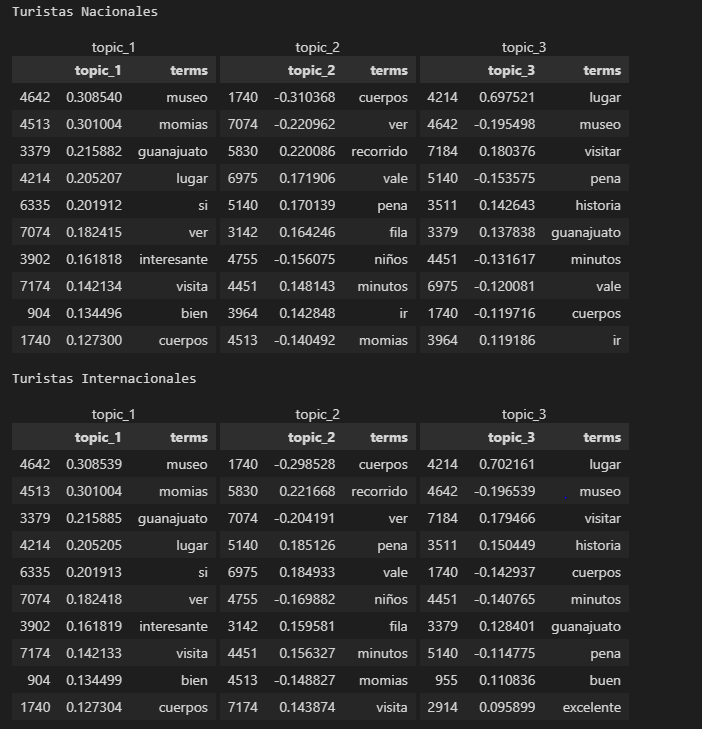

Para saber cuales son las diferencias entre opiniones y temas sobre el lugar según los turistas nacionales e internacionales, es posible hacer uso del Latent Semantic Analisis, que determina la importancia o el peso de cada palabra en un tema en específico (de manera no supervisada). Los valores pueden ser positivos, negativos o cercanos a cero. Los valores positivos indican que la palabra está más asociada al tema, mientras que los valores negativos indican que la palabra está más alejada o contraria al tema. No obstante, cuando los valores son muy cercanos a 0 significa que las palabras son menos relevantes para el tema. 
Teniendo lo anterior en cuenta y analizando las tablas, podemos ver que en el tópico 3 los turistas internacionales mencionan más las palabras ‘buen’ y ‘excelente’ en comparación de los turistas nacionales, esto quiere decir que tienen mayor valoración y apreciación por el museo. 
Por otro lado, en el tópico 2, que hace más referencia a la satisfacción o disfrute que las personas tienen sobre el lugar, los turistas nacionales parecen tener una mayor sensibilidad a los cuerpos encontrados en el museo (aunque tampoco muy lejano a los turistas fuera de la nación), mientras que los turistas internacionales parecen estar más influenciados por las percepciones de los niños sobre el museo y las momias. 
Cabe destacar que en el tópico 1 ambos tipos de turistas comparten palabras muy generales del lugar, al tratarse evidentemente de un museo en Guanajuato enfocado a las momias. 

3. (10pts) ¿Cual diría que es el sitio que le gusta más a las mujeres y por qué?

In [138]:
arreglo_ordenado = sorted(average_and_std_woman, key=lambda x: x[1])
print(arreglo_ordenado)

[(4.73, 0.49, 'TeatroJuárez'), (4.64, 0.57, 'UniversidaddeGuanajuato'), (4.62, 0.61, 'JardíndelaUnión'), (4.58, 0.64, 'BasilicaColegiata'), (4.43, 0.75, 'MonumentoPípila'), (4.44, 0.76, 'Alhóndiga'), (4.25, 0.82, 'CasadeDiegoRivera'), (4.01, 0.93, 'MercadoHidalgo'), (4.04, 0.95, 'CallejóndelBeso'), (3.69, 1.15, 'MuseodelasMomias')]


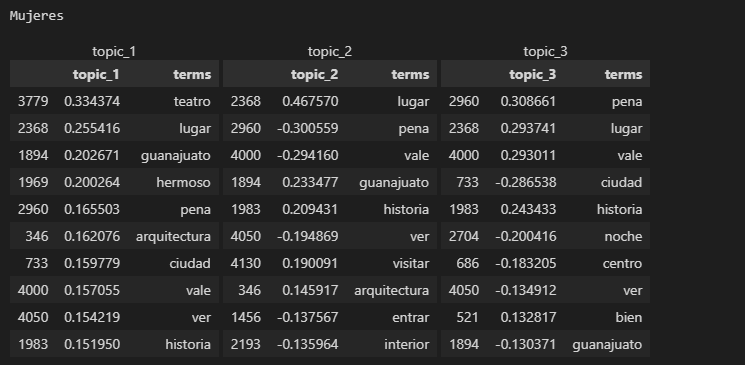

In [139]:
arreglo_ordenado = sorted(average_and_std, key=lambda x: x[1])
print(arreglo_ordenado)

[(4.7, 0.52, 'TeatroJuárez'), (4.59, 0.61, 'JardíndelaUnión'), (4.6, 0.61, 'UniversidaddeGuanajuato'), (4.5, 0.67, 'BasilicaColegiata'), (4.45, 0.75, 'Alhóndiga'), (4.38, 0.77, 'MonumentoPípila'), (4.24, 0.8, 'CasadeDiegoRivera'), (3.95, 0.95, 'MercadoHidalgo'), (4.0, 0.97, 'CallejóndelBeso'), (3.68, 1.14, 'MuseodelasMomias')]


El Teatro Juárez es el lugar favorito de las mujeres en Guanajuato, según sus opiniones. Le dan una puntuación muy alta de 4.73 y hay mucho acuerdo entre ellas, ya que la desviación estándar es solo de 0.49. El LSA muestra que el teatro les parece un lugar hermoso, que vale la pena visitar, especialmente de noche. También valoran su historia, su arquitectura y su belleza interior. De hecho, esta percepción no se limita únicamente a las mujeres, pues el score general del lugar es muy bueno y la desviación estándar de 0.52 sigue siendo baja, siendo así uno de los mejores lugares a visitar en Guanajuato. Quizá el único detalle en contra sobre el teatro sería que en la nube de palabras aparece la palabra 'caro', pero realmente esto puede llegar a ser un tema debatido, porque depende del tipo de evento al que se quiera asistir, pues según información de Google la entrada cuesta 35 pesos mexicanos.  

4. (10pts) ¿Cual diría que es el sitio que le gusta más a las personas jóvenes y por qué?

In [142]:
arreglo_ordenado = sorted(average_and_std_young, key=lambda x: x[1])
print(arreglo_ordenado)

[(4.75, 0.49, 'TeatroJuárez'), (4.65, 0.55, 'UniversidaddeGuanajuato'), (4.58, 0.63, 'JardíndelaUnión'), (4.48, 0.69, 'BasilicaColegiata'), (4.45, 0.73, 'Alhóndiga'), (4.41, 0.76, 'MonumentoPípila'), (4.22, 0.77, 'CasadeDiegoRivera'), (4.03, 0.9, 'MercadoHidalgo'), (4.09, 0.93, 'CallejóndelBeso'), (3.76, 1.13, 'MuseodelasMomias')]


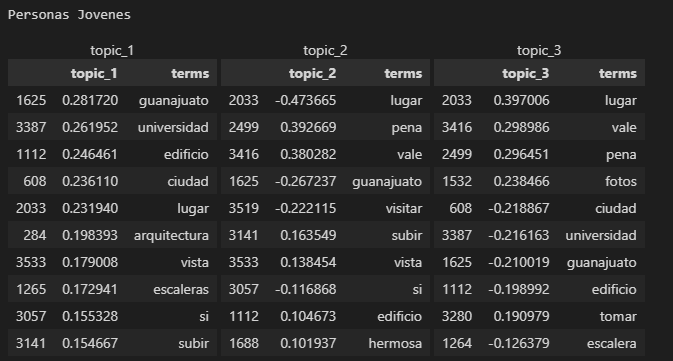

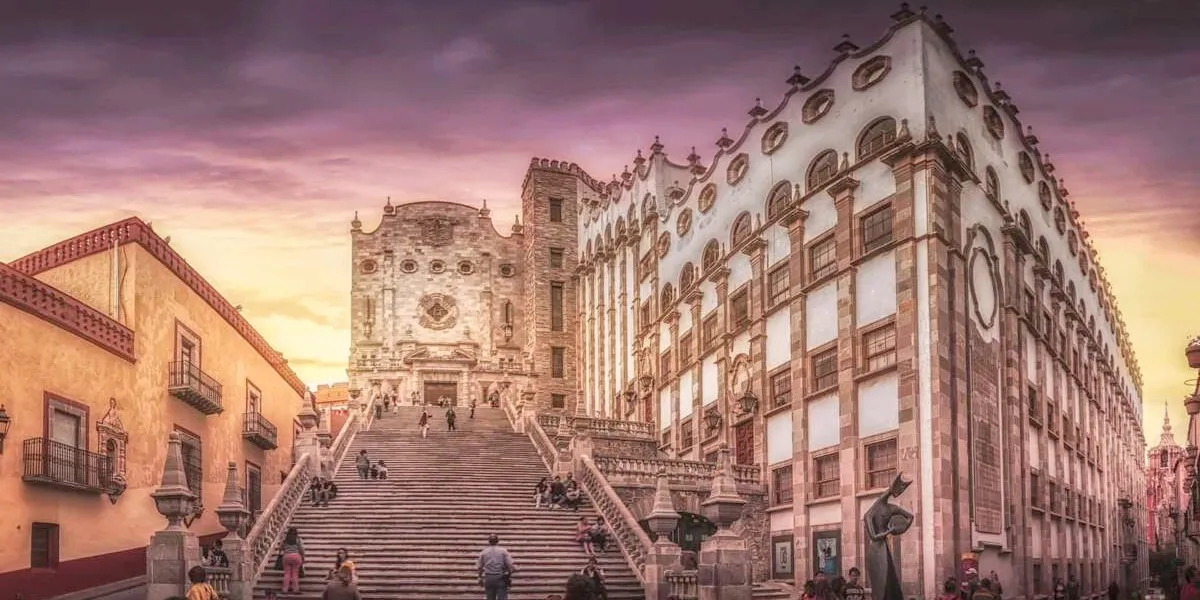

Entre los lugares más visitados y apreciados por los jóvenes viajeros menores de 30 años en Guanajuato, se encuentra el Teatro Juárez, con un puntaje de 4.75. Este lugar es el favorito de muchos por su historia, su belleza y su arquitectura, como ya se explicó anteriormente. Pero no es el único que atrae a los jóvenes, ya que la Universidad de Guanajuato también tiene un gran encanto y una gran importancia en la ciudad. La Universidad es el alma muchos de estudiantes y también es un espacio donde se realizan diversas actividades culturales. Uno de los aspectos más llamativos de la Universidad es su escalinata, que se ve en la imagen de arriba. Esta escalera es un símbolo de la universidad y un lugar ideal para tomar fotos espectaculares, por tal motivo es un tema relativamente mencionado en el tópico 3 del LSA. La arquitectura antigua y la vista panorámica de la ciudad que ofrece la Universidad también son elementos que la hacen un lugar inolvidable en Guanajuato.

5. (10pts) ¿Qué otras observaciones valiosas puede obtener de su análisis? (e.g., ¿identificó
de que se queja la gente? ¿qué tipo de cosas le gustó a la gente?, etc.)

Respondiendo directamente a las últimas dos preguntas sugeridas, los lugares que más disgustan a la gente son los que están descuidados, sucios, malolientes o inseguros. También los que no cumplen con las expectativas o decepcionan. Los lugares que más gustan a la gente son los que tienen historia, arquitectura, belleza y excepcionalidad. También los que están bien cuidados y conservados. Estos suelen ser características que los todos los lugares tienen que lidiar para atraer la atención de la población. 

Una observación adicional es que el turismo en Guanajuato aumentó considerablemente en el 2016. Esto se puede corroborar con en análisis temporal hecho a través de los años y leyendo los siguientes artículos:
    
https://boletines.guanajuato.gob.mx/2016/08/23/derrama-historica-para-guanajuato-en-turismo/

https://aristeguinoticias.com/0902/kiosko/guanajuato-aumento-turismo-en-2016/

https://www.gob.mx/sectur/prensa/registra-turismo-cifras-historicas-en-2016-35-millones-de-visitantes-y-19-571-mdd-en-divisas

No obstante, a partir del 2017 el turismo ha decaído. 

Otra observación interesante es que la mayoría de las opiniones se escribieron en una computadora o laptop, y no en un celular. Esto podría ser una oportunidad de mejora para Tripadvisor y su presencia digital en los dispositivos móviles.

Nota: los resultados del LSA en las imagenes de las tablas que aparecen en la sección de preguntas pueden cambiar ligeramente, debido a que se necesitó de ejecutar el notebook varias veces depués de haber tomado las capturas